In [1]:
# Install all libraries needed for producing plots that are not already available in the Object
# Detection Docker image.

!pip install --upgrade pip
!pip install seaborn
!pip install sklearn
!pip install geopandas
!pip install shapely
!pip install fiona
!pip install descartes
!pip install statsmodels
!pip install pingouin
!pip install squarify
!apt install libspatialindex-dev python3-rtree -y
!pip3 install Rtree
!pip3 install geopy

     |████████████████████████████████| 1.7MB 24.9MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 292 kB 16.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=4294 sha256=54eafb384df2fb633009ff0a1c3af8658459cdae3e920249cd0b861ae27f3e78
  Stored in directory: /root/.cache/pip/wheels/a8/20/b1/0b08c6071caf725f6b3f48c30faec4a855bcae02df1e61ed6c
Successfully built sklearn
     |████████████████████████████████| 994 kB 18.2 MB/s            
     |████████████████████████████████| 16.6 MB 95.0 MB/s            
     |████████████████████████████████| 2.0 MB 81.3 MB/s            
     |████████████████████████████████| 6.5 MB 36.8 MB/s            
     |████████████████████████████████| 161 kB 55.3 MB/s            
     |████████████████████████████████| 97 kB 7.6 MB/s             


     |████████████████████████████████| 9.5 MB 30.0 MB/s            
     |████████████████████████████████| 233 kB 103.9 MB/s            
     |████████████████████████████████| 185 kB 19.5 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 14.8 MB 97.6 MB/s            
     |████████████████████████████████| 183 kB 86.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 182 kB 86.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 206 kB 84.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 205 kB 92.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 22.2 MB 48.9 MB/s            
     |████████████████████████████████| 736 kB 88.2 MB/s            
     |████████████████████████████████| 63 kB 1.6 MB/s             
  Preparing metadata (setup.py) ..

    Uninstalling setuptools-41.4.0:
      Successfully uninstalled setuptools-41.4.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5 python3-rtree
0 upgraded, 4 newly installed, 0 to remove and 1 not upgraded.
Need to get 572 kB of archives.
After this operation, 3418 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-rtree all 0.8.3+ds-1 [16.9 kB]
Fetched 572 kB in 1s (870

In [2]:
# Import relevant libraries

import os
import sys
import math
sys.path.append("../..")
import ast
import datetime
import glob
import re
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
   DayLocator, MONDAY
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns
import scipy as sp
from sklearn import linear_model
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
import pingouin
import squarify
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.ops import nearest_points
import rtree
import geopandas

/usr/local/lib/python3.6/dist-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

In [4]:
# Every week's camera imagery from a given site is processed by the OD algorithm and stored as a text file.
# The function below converts the output of that file into a Pandas dataframe.

PATH_TO_LABELS = os.path.join('../labels', 'accra_map.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

def pd_from_site(site, model, file_path = '../results/detections/detections_data/'):
    object_detections = []

    with open(file_path+site+'/Object_Detections_'+model+'.txt', 'r') as f:
        for line in f:
            s = line
            dict = ast.literal_eval(s)
            object_detections.append(dict)
    object_dataframe = pd.DataFrame(object_detections)
    
    for output in object_detections:
        for i in range(len(output['detection_classes'])):    
            if not isinstance(output['detection_classes'][i], str):
                output['detection_classes'][i] = category_index[int(output['detection_classes'][i])]['name']
    
    return object_dataframe

In [5]:
# Structure for organising each site and the cameras at each site.

# Long term sites 
site_cams = {'AD' : ['C4', 'C17', 'C12', 'C14'],
             'ASH' : ['C6', 'C13'],
             'EL' : ['C12', 'C32', 'C01', 'C8', 'C18', 'C28', 'C10'],
             'JT' : ['C31', 'C21', 'C11', 'C9'],
             'LA' : ['C16', 'C35'],
             'N1West' : ['C36', 'C15', 'C33'],
             'Nima' : ['C2', 'C27','C13', 'C26'],
             'Taifa' : ['C21', 'C22'],
             'TMW' : ['C30', 'C19'],
             'UGH' : ['C5','C12','C23','C33','C25']}

dirs = []

# Short term sites
sitelist = [x[:x.index('_')] for x in os.listdir('../results/detections/detections_data/') if (x[0] == 'S')]

for site in sitelist:
    cams = ['C'+re.search('C(\d+)', x).group(1) for x in os.listdir('../results/detections/detections_data/') if ((x[:len(site)+1] == site+'_'))]
    site_cams[site] = []
    for cam in cams:
        site_cams[site].append(cam)

In [26]:
# Import all data as dataframes (organised by site and camera in a python dictionary)
# object_data = {site:{cam:pd.DataFrame() for cam in site_cams[site]} for site in site_cams}
 
# for site in site_cams:
#     for cam in site_cams[site]:
#         #print(site+' '+cam)
#         dirlist = [x for x in os.listdir('../results/detections/detections_data/') if ((x[:len(site)+1] == site+'_') and ('C'+re.search('C(\d+)', x).group(1) == cam))]
#         model = '1000'

#         dirs.extend(dirlist)
        
#         for dir_path in dirlist:
#             object_data2 = pd_from_site(dir_path, model)
#             object_data2['directory'] = dir_path
#             object_data[site][cam] = pd.concat([object_data[site][cam],object_data2], ignore_index = True)

AD C4
AD C17
AD C12
AD C14
ASH C6
ASH C13
EL C12
EL C32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



EL C01
EL C8
EL C18
EL C28
EL C10
JT C31
JT C21
JT C11
JT C9
LA C16
LA C35
N1West C36
N1West C15
N1West C33
Nima C2
Nima C27
Nima C13
Nima C26
Taifa C21
Taifa C22
TMW C30
TMW C19
UGH C5
UGH C12
UGH C23
UGH C33
UGH C25
S76 C8
S76 C28
S25 C42
S25 C44
S31 C43
S36 C44
S36 C13
S60 C41
S87 C11
S87 C42
S103 C23
S103 C8
S49 C50
S105 C44
S105 C42
S124 C42
S61 C41
S61 C8
S138 C32
S92 C16
S92 C36
S7 C23
S7 C13
S53 C5
S53 C13
S1 C44
S1 C40
S64 C41
S29 C42
S29 C13
S104 C43
S104 C41
S118 C8
S120 C8
S120 C13
S72 C20
S42 C40
S42 C44
S14 C20
S14 C41
S165 C41
S106 C44
S106 C13
S30 C42
S39 C43
S39 C13
S85 C13
S85 C8
S98 C5
S132 C43
S8 C41
S8 C5
S154 C5
S154 C40
S113 C20
S113 C8
S108 C5
S108 C44
S35 C40
S35 C8
S34 C43
S139 C43
S139 C41
S82 C8
S82 C43
S159 C44
S159 C20
S114 C20
S114 C44
S100 C8
S100 C5
S102 C42
S102 C20
S19 C8
S26 C41
S26 C20
S50 C20
S50 C8
S73 C23
S27 C28
S27 C11
S125 C13
S3 C28
S3 C40
S59 C20
S59 C43
S58 C43
S58 C40
S32 C13
S52 C44
S52 C43
S101 C13
S101 C42
S168 C13
S168 C41
S77 C44
S146

In [7]:
# Sum counts in a given image of a given object category, fix datetime index

def fix_datetimes(image_name, site, cam):
    corrected_datetimes = pd.concat((pd.read_csv('../corrected_datetimes/'+x) for x in os.listdir('../corrected_datetimes/') if ((x[:len(site)+1] == site+'_') and ('C'+re.search('C(\d+)', x).group(1) == cam))))
    #corrected_datetimes = pd.read_csv('../corrected_datetimes/'+[x for x in os.listdir('../corrected_datetimes/') if ((x[:len(site)+1] == site+'_') and ('C'+re.search('C(\d+)', x).group(1) == cam))][0])
    return corrected_datetimes[corrected_datetimes['name_image'] == image_name]['timestamp_corrected'].values[0]

def sum_and_sort(object_data_frame):
    for j in range(1,len(category_index)+1):
        object_data_frame[category_index[j]['name']+'_counts'] = ""

    for i in range(0,len(object_data_frame['datetime'])):
        for j in range(1,len(category_index)+1):
            object_data_frame[category_index[j]['name']+'_counts'][i] = object_data_frame['detection_classes'][i].count(category_index[j]['name'])
            
    object_data_frame['datetime'] = pd.to_datetime(object_data_frame['datetime'], format='%Y:%m:%d %H:%M:%S', errors='coerce')
    object_data_frame.sort_values(by=['datetime'], inplace = True)
    object_data_frame.set_index('datetime', inplace=True)
    object_data_frame['hm'] = object_data_frame.index.strftime("%H%M")
    
def sum_and_sort_merge(object_data_frame, site):

    cam_cols = [cam for cam in site_cams[site] if cam in "".join(object_data_frame.columns)]
        
#     for j in range(1,len(category_index)+1):
#         object_data_frame[category_index[j]['name']+'_counts'] = object_data_frame[category_index[j]['name']+'_counts_'+cam_cols[0]] + object_data_frame[category_index[j]['name']+'_counts_'+cam_cols[1]]

    object_data_frame['datetime'] = pd.to_datetime(object_data_frame['datetime'], format='%Y:%m:%d %H:%M:%S', errors='coerce')
    object_data_frame.sort_values(by=['datetime'], inplace = True)
    object_data_frame.set_index('datetime', inplace=True)    
    
for site in site_cams:
    for cam in site_cams[site]:
        if not('hm' in object_data[site][cam].columns):
            sum_and_sort(object_data[site][cam])
        # Some cameras recorded images with incorrect date and timestamps, which the code below fixes.
        if(object_data[site][cam].index[0] <= datetime.datetime(2019,3,30)):
            print(site+' '+cam)
            date_bool = object_data[site][cam].index <= datetime.datetime(2019,3,30)
            dummy_frame = object_data[site][cam][date_bool]
            dummy_frame['datetime'] = dummy_frame.apply(lambda x: fix_datetimes(x['image_name'], site, cam), axis=1)
            dummy_frame['datetime'] = pd.to_datetime(dummy_frame['datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
            dummy_frame.set_index('datetime', inplace=True)
            object_data[site][cam] = object_data[site][cam].drop(object_data[site][cam][date_bool].index)
            object_data[site][cam] = pd.concat([object_data[site][cam],dummy_frame], ignore_index = False)
            

In [4]:
vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

super_categories = {'people' : ['person','vendor'],
                    'small_vehicles' : ['car', 'taxi','truck'],
                    'two_wheelers' : ['bicycle', 'motorcycle'],
                    'large_vehicles' : ['trotro', 'van', 'lorry','bus'],
                    'refuse' : ['trash', 'debris'],
                    'market': ['umbrella','stall','bowl','food'],
                    'paratransit': ['taxi','trotro']}

# for site in site_cams:
#     for cam in site_cams[site]:
#         object_data[site][cam]['vehicle_counts'] = 0
#         object_data[site][cam]['hour'] = object_data[site][cam].index.strftime("%H")
#         for vehicle in vehicle_categories:
#             object_data[site][cam]['vehicle_counts'] += object_data[site][cam][vehicle+'_counts']
#         for super_category in super_categories:
#             object_data[site][cam][super_category+'_counts'] = 0
#             for cat in super_categories[super_category]:
#                 object_data[site][cam][super_category+'_counts'] += object_data[site][cam][cat+'_counts']
    

In [ ]:
# Produce some relevant metadata regarding the imagery used in this analysis

print("Number of rotating sites: "+str(len([site for site in site_cams if site[0] == 'S'])))
print("Number of fixes sites: "+str(len([site for site in site_cams if site[0] != 'S'])))

rotating_len=0
fixed_len=0
rotating_obj_sum=0
fixed_obj_sum=0
two_cam_rotating_sites=0
one_cam_rotating_sites=0
for site in site_cams:
    if(site.lower()[0] == 's'):
        if(len(site_cams[site]) == 1):
            one_cam_rotating_sites+=1
        else:
            two_cam_rotating_sites+=1
#     for cam in site_cams[site]:
#         if(site.lower()[0] == 's'):
#             rotating_len+=len(object_data[site][cam])
#             rotating_obj_sum+=object_data[site][cam][[cat+'_counts' for cat in categories]].sum().sum()
#         else:
#             fixed_len+=len(object_data[site][cam])
#             fixed_obj_sum+=object_data[site][cam][[cat+'_counts' for cat in categories]].sum().sum()

print("Number of images: "+str(fixed_len+rotating_len))
print("Number of objects: "+str(rotating_obj_sum+fixed_obj_sum))
print("Number of rotating sites images: "+str(rotating_len))
print("Number of rotating sites objects: "+str(rotating_obj_sum))
print("Number of fixed sites images: "+str(fixed_len))
print("Number of fixed sites objects: "+str(fixed_obj_sum))
print("Number of one camera rotating sites: "+str(one_cam_rotating_sites))
print("Number of two camera rotating sites: "+str(two_cam_rotating_sites))
print("Number of one camera fixed sites: 3")
print("Number of two camera fixed sites: 7")

In [44]:
# Adding site metadata 

site_cats = pd.read_csv('site_cats.csv')
site_roads = pd.read_csv('site_road_types_2.csv')
site_pop_dens_ndvi= pd.read_csv('site_pop_dens_ndvi.csv')

# Mapping OpenStreetMap (2019) code categorisations to our definitions.
road_codes = {5122: 'minor', 5121: 'minor', 5115: 'medium', 5114: 'major', 5141: 'minor', 5135: 'medium', 5113: 'major', 5133: 'major'}
site_roads.code.replace(road_codes,inplace=True)

for site in site_cams:
    for cam in site_cams[site]:
        if(len(object_data[site][cam]) > 1):
            object_data[site][cam]['site_type'] = None
            object_data[site][cam]['lat'] = None
            object_data[site][cam]['lon'] = None    
            object_data[site][cam]['WB_cat'] = None
            object_data[site][cam]['pop_dens_cat'] = None
            object_data[site][cam]['ndvi_cat'] = None
            object_data[site][cam]['pop_dens'] = None
            object_data[site][cam]['ndvi'] = None    
            object_data[site][cam]['road_surface'] = None
            object_data[site][cam]['road_type'] = None
            site_bool = np.logical_or(site_cats['ID'] == site.lower(), site_cats['ID'] == site)
            object_data[site][cam]['site_type'] = site_cats.loc[site_bool]['site_type'].values[0]
            object_data[site][cam]['lat'] = site_cats.loc[site_bool]['Lat'].values[0]
            object_data[site][cam]['lon'] = site_cats.loc[site_bool]['Lon'].values[0]
            object_data[site][cam]['WB_cat'] = site_cats.loc[site_bool]['WB_cat'].values[0]
            object_data[site][cam]['pop_dens_cat'] = site_pop_dens_ndvi.loc[site_bool]['pop_dens_cat'].values[0]
            object_data[site][cam]['pop_dens'] = site_pop_dens_ndvi.loc[site_bool]['pop_den'].values[0]
            object_data[site][cam]['ndvi_cat'] = site_pop_dens_ndvi.loc[site_bool]['ndvi_cat'].values[0]
            object_data[site][cam]['ndvi'] = site_pop_dens_ndvi.loc[site_bool]['ndvi'].values[0]
            object_data[site][cam]['road_surface'] = site_cats.loc[site_bool]['Road_surface'].values[0].lower()
            object_data[site][cam]['road_type'] = site_roads.loc[site_roads['site'] == site]['code'].values[0]

AD
AD
AD
AD
ASH
ASH
EL
EL
EL
EL
EL
EL
EL
JT
JT
JT
JT
LA
LA
N1West
N1West
N1West
Nima
Nima
Nima
Nima
Taifa
Taifa
TMW
TMW
UGH
UGH
UGH
UGH
UGH
S76
S76
S25
S25
S31
S36
S36
S60
S87
S87
S103
S103
S49
S105
S105
S124
S61
S61
S138
S92
S92
S7
S7
S53
S53
S1
S1
S64
S29
S29
S104
S104
S118
S120
S120
S72
S42
S42
S14
S14
S165
S106
S106
S30
S39
S39
S85
S85
S98
S132
S8
S8
S154
S154
S113
S113
S108
S108
S35
S35
S34
S139
S139
S82
S82
S159
S159
S114
S114
S100
S100
S102
S102
S19
S26
S26
S50
S50
S73
S27
S27
S125
S3
S3
S59
S59
S58
S58
S32
S52
S52
S101
S101
S168
S168
S77
S146
S135
S135
S28
S28
S79
S79
S83
S83
S51
S51
S88
S88
S112
S112
S69
S69
S136
S136
S136
S136
S56
S56
S97
S97
S78
S66
S66
S47
S33
S150
S150
S80
S80
S18
S18
S57
S57
S20
S81
S81
S166
S166
S67
S67
S6
S6
S71
S86
S86
S117
S21
S21
S126
S126
S129
S129
S93
S93
S43
S41
S37
S37
S133
S133
S111
S111
S90
S90
S12
S122
S62
S62
S116
S116
S107
S40
S109
S109
S65
S65
S22
S22
S0
S121
S94
S94
S4
S68
S13
S131
S147
S110
S10
S143
S54
S54
S119
S119
S11
S153
S153
S160
S9

In [101]:
# Create dataframes with information about all sites (for correlations across sites)

object_data['sums'] = {'site_cams':pd.DataFrame()}

sum_categories = categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','paratransit']
for site in site_cams:
    for cam in site_cams[site]:
        print(site+' '+cam)
        if(len(object_data[site][cam]) < 1):
            print(site)
            print(cam)
            print(int(len(object_data[site][cam])))
        else:
            site_counts = dict(object_data[site][cam][[cat+'_counts' for cat in sum_categories]].sum().sort_values(ascending=False))
            site_counts['site_cam']=site+"_"+cam
            site_counts['ndvi']=object_data[site][cam]['ndvi'][0]
            site_counts['pop_dens']=object_data[site][cam]['pop_dens'][0]
            #print(site)
            for cat in sum_categories:          
                site_counts[cat] = [float(int(site_counts[cat+'_counts'])/(len(object_data[site][cam])))]
                site_counts[cat+'_counts'] = [float(int(site_counts[cat+'_counts']))]
            site_counts['im_len'] = [float(len(object_data[site][cam]))]
            object_data['sums']['site_cams'] = pd.concat([object_data['sums']['site_cams'],pd.DataFrame(site_counts)], ignore_index = True)
        
object_data['sums']['sites'] = pd.DataFrame()

sum_categories = categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','paratransit']
for site in site_cams:
    site_counts = dict()
    site_counts['site']=site
    site_counts['ndvi']=object_data[site][site_cams[site][0]]['ndvi'][0]
    site_counts['pop_dens']=object_data[site][site_cams[site][0]]['pop_dens'][0]
    for cat in sum_categories:          
        site_counts[cat+'_counts'] = [0]
    site_counts['im_len']= [0]    
    for cam in site_cams[site]:
        #print(site+' '+cam)
        if(len(object_data[site][cam]) < 1):
            print(site)
            print(cam)
            print(int(len(object_data[site][cam])))
        else:
            for cat in sum_categories:          
                site_counts[cat+'_counts'][0] += float(object_data[site][cam][cat+'_counts'].sum())
            site_counts['im_len'][0]+= float(len(object_data[site][cam]))
    for cat in sum_categories:          
        site_counts[cat] = [float(site_counts[cat+'_counts'][0]/site_counts['im_len'][0])]
    object_data['sums']['sites'] = pd.concat([object_data['sums']['sites'],pd.DataFrame(site_counts)], ignore_index = True)
        

AD C4
AD C17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



AD C12
AD C14
ASH C6
ASH C13
EL C12
EL C32
EL C01
EL C8
EL C18
EL C28
EL C10
JT C31
JT C21
JT C11
JT C9
LA C16
LA C35
N1West C36
N1West C15
N1West C33
Nima C2
Nima C27
Nima C13
Nima C26
Taifa C21
Taifa C22
TMW C30
TMW C19
UGH C5
UGH C12
UGH C23
UGH C33
UGH C25
S76 C8
S76 C28
S25 C42
S25 C44
S31 C43
S36 C44
S36 C13
S60 C41
S87 C11
S87 C42
S103 C23
S103 C8
S49 C50
S105 C44
S105 C42
S124 C42
S61 C41
S61 C8
S138 C32
S92 C16
S92 C36
S7 C23
S7 C13
S53 C5
S53 C13
S1 C44
S1 C40
S64 C41
S29 C42
S29 C13
S104 C43
S104 C41
S118 C8
S120 C8
S120 C13
S72 C20
S42 C40
S42 C44
S14 C20
S14 C41
S165 C41
S106 C44
S106 C13
S30 C42
S39 C43
S39 C13
S85 C13
S85 C8
S98 C5
S132 C43
S8 C41
S8 C5
S154 C5
S154 C40
S113 C20
S113 C8
S108 C5
S108 C44
S35 C40
S35 C8
S34 C43
S139 C43
S139 C41
S82 C8
S82 C43
S159 C44
S159 C20
S114 C20
S114 C44
S100 C8
S100 C5
S102 C42
S102 C20
S19 C8
S26 C41
S26 C20
S50 C20
S50 C8
S73 C23
S27 C28
S27 C11
S125 C13
S3 C28
S3 C40
S59 C20
S59 C43
S58 C43
S58 C40
S32 C13
S52 C44
S52 C43
S101 

In [8]:
# The categorisation of Labadi is actually different to that
# recorded from the log forms. This is because for pollution monitoring 
# purposes, Labadi's location by the sea makes it more akin to 
# a "background" site for that purpose, but is not peri-urban.

for cam in site_cams['LA']:
    object_data['LA'][cam]['site_type'] = 'low-dens'

In [6]:
#pickle.dump( object_data, open( "object_data_final.p", "wb" ) )
object_data = pickle.load(open("notebooks/object_data_final.p", "rb" ))

In [7]:
# Show many objects of each kind there are in our dataset
obj_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash', 'vendor', 'loudspeaker', 'stove', 'bus']

print(object_data['sums']['sites'][[cat+'_counts' for cat in obj_categories]].sum())

person_counts         9663741.0
umbrella_counts       3002257.0
stall_counts           143841.0
food_counts             49672.0
bowl_counts            209043.0
car_counts            4190980.0
taxi_counts           1275854.0
truck_counts           353325.0
bicycle_counts         102620.0
motorcycle_counts      258434.0
animal_counts           36712.0
trotro_counts         2942124.0
van_counts             176065.0
lorry_counts           163874.0
debris_counts          298609.0
trash_counts           604008.0
vendor_counts              98.0
loudspeaker_counts          0.0
stove_counts                0.0
bus_counts                 14.0
dtype: float64


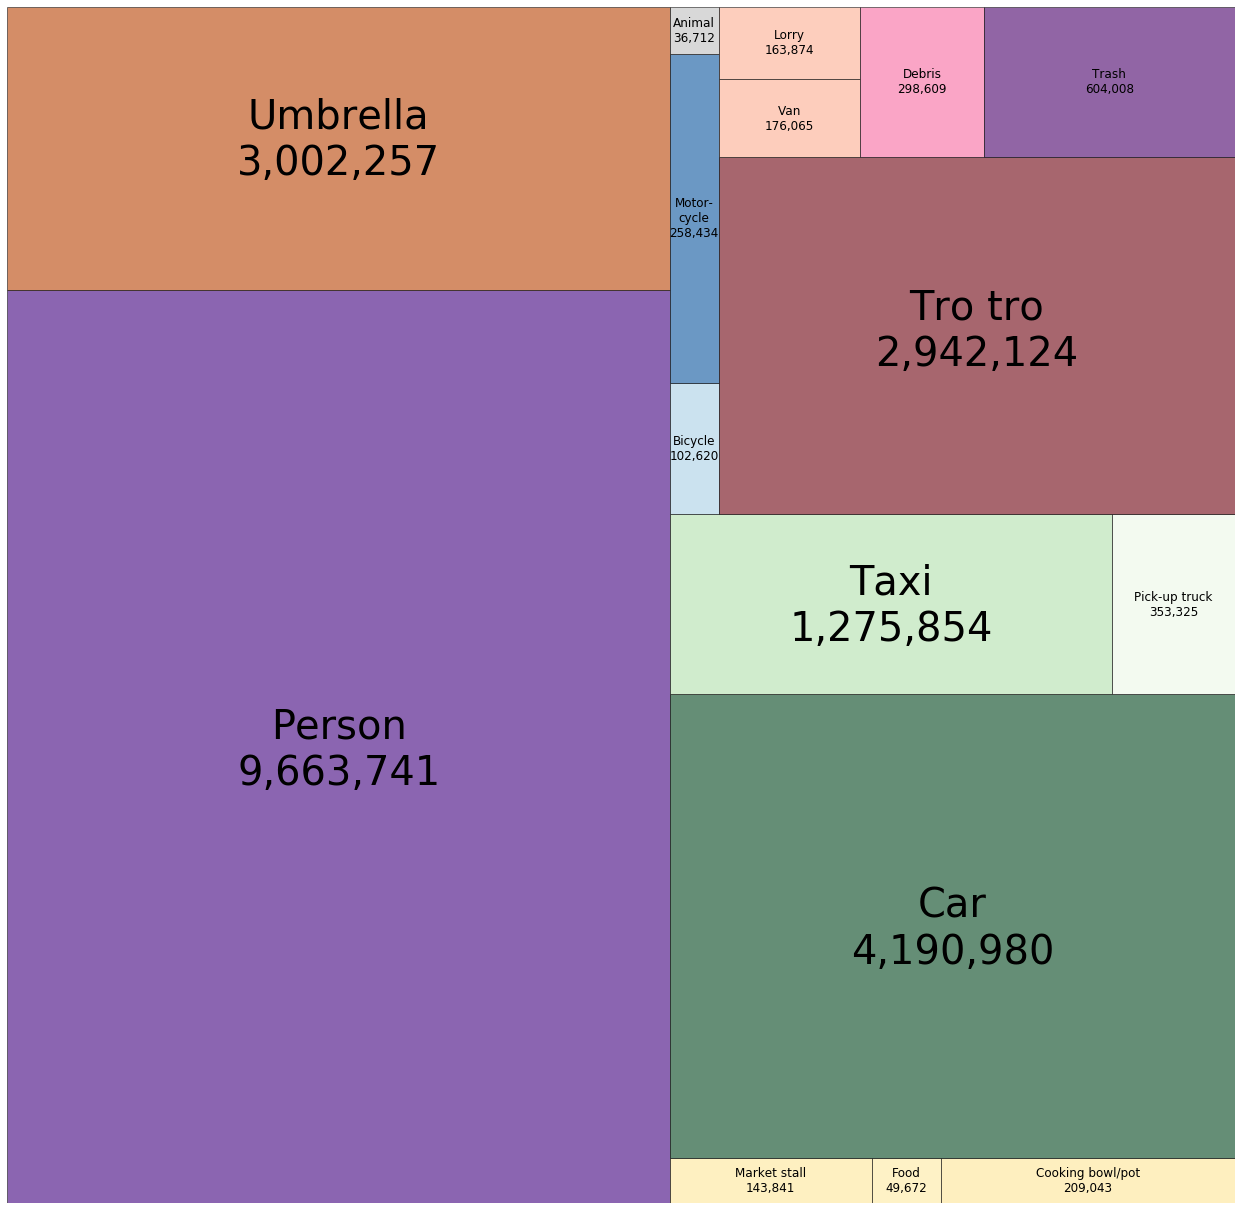

In [19]:
# Treemap generation

import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(22,22),linewidth=0)

tree_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash']

total_counts = object_data['sums']['sites'][[cat+'_counts' for cat in tree_categories]].sum()#.sort_values(ascending=False)

sizes=[float(size/10000) for size in total_counts.values]

label=[obj[0].replace("trotro","tro tro")
             .replace("truck","pick-up truck")
             .replace("stall","market stall")
             .replace("bowl","cooking bowl/pot")
             .replace("_counts","\n"+str(f"{int(obj[1]):,}")).capitalize().replace("rcycle","r-\ncycle") for obj in zip(total_counts.index,total_counts.values)]
label_mod=label.copy()

for i in [0,1,5,6,11]:
    label_mod[i]= ""

cmap_1 = plt.cm.Purples
cmap_2 = plt.cm.YlOrBr
cmap_3 = plt.cm.Greens
cmap_4 = plt.cm.Blues
cmap_5 = plt.cm.Greys
cmap_6 = plt.cm.Reds
cmap_7 = plt.cm.RdPu

norm_1 = colors.Normalize(vmin=0, vmax=4000000)
norm_2 = colors.Normalize(vmin=-1000000, vmax=4000000)
norm_3 = colors.Normalize(vmin=0, vmax=4000000)
norm_4 = colors.Normalize(vmin=0, vmax=300000)
norm_5 = colors.Normalize(vmin=0, vmax=100000)
norm_6 = colors.Normalize(vmin=-1000000, vmax=3000000)
norm_7 = colors.Normalize(vmin=0, vmax=600000)

colors = [cmap_1(norm_1(value)) for value in total_counts.values[:1]]+\
         [cmap_2(norm_2(value)) for value in total_counts.values[1:5]]+\
         [cmap_3(norm_3(value)) for value in total_counts.values[5:8]]+\
         [cmap_4(norm_4(value)) for value in total_counts.values[8:10]]+\
         [cmap_5(norm_5(value)) for value in total_counts.values[10:11]]+\
         [cmap_6(norm_6(value)) for value in total_counts.values[11:14]]+\
         [cmap_7(norm_7(value)) for value in total_counts.values[14:]]

#print(label)
squarify.plot(sizes=sizes, label=label_mod, color=colors, alpha=0.6,text_kwargs={'fontsize':12, 'color':'black', 'fontweight':"medium"},bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
fontsize = 40
plt.text(27,35, label[0], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(27, 86, label[1], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(77, 20, label[5], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(72, 47, label[6], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(79, 70, label[11], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.axis('off')
plt.show()
fig.savefig('../results/treemap_final.pdf',format='pdf',edgecolor="#000000", bbox_inches='tight', pad_inches=0.1)

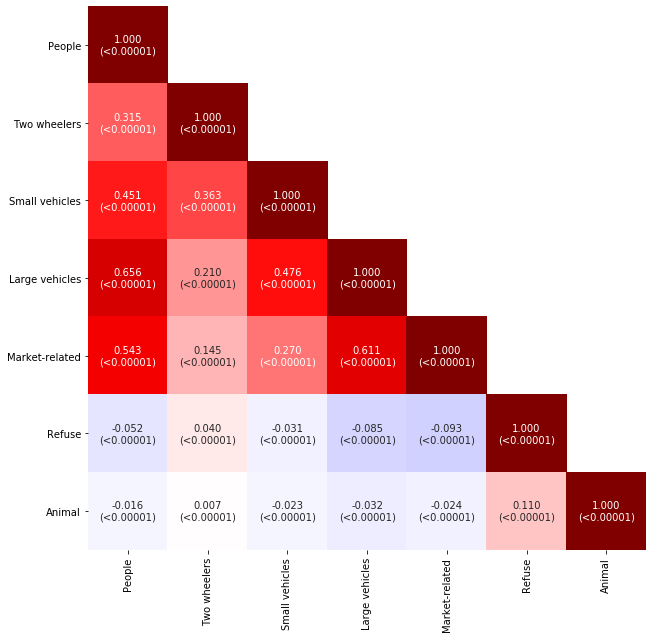

In [61]:
# Site correlations

corr_site = 'sums'
f
fig, ax = plt.subplots(figsize=(10,10))
#corr_frame = object_data[corr_site]['sites']

#corr_categories = ['person', 'car', 'trash', 'trotro', 'debris', 'taxi', 'umbrella', 'truck', 'lorry', 'motorcycle', 'stall', 'van', 'animal', 'food', 'bicycle', 'bowl']
#corr_categories = ['person', 'bicycle', 'motorcycle', 'car', 'taxi', 'truck', 'trotro', 'van', 'lorry', 'umbrella', 'stall', 'food', 'bowl', 'animal', 'debris', 'trash']
corr_categories = ['people','two_wheelers','small_vehicles', 'large_vehicles', 'market', 'refuse', 'animal']

## This can be used instead of the correlation frame given above if one wishes for the correlation across all images instead of sites
multi_frame = []
for site in site_cams:
    for cam in site_cams[site]:
        multi_frame.append(object_data[site][cam].rename(columns={col+"_counts": col for col in corr_categories})[[col for col in corr_categories]])
corr_frame = pd.concat(multi_frame)

cmap = 'seismic'
method = 'pearson'

# FOR P VALUES
p_frame = corr_frame[[obj for obj in corr_categories]].astype(float).rcorr(method=method, stars=False)

for obj in corr_categories:
    p_frame[obj][obj] = 0
    corr_frame[obj][obj] = 1

# FOR ACTUAL CORRELATION COEFFICIENTS
corr_frame = corr_frame[[obj for obj in corr_categories]].astype(float).corr(method=method)

text = np.asarray(p_frame.T)

labels = (np.asarray(["{:.3f}\n({:.5f})".format(float(data),float(text)) for text, data in zip(text.flatten(), corr_frame.to_numpy().flatten())])).reshape(7,7)

for j,row in enumerate(labels):
    for i,text in enumerate(row):
        labels[j][i]=text.replace("(0.00000)","(<0.00001)")

mask = np.triu(np.ones_like(corr_frame, dtype=bool))

for i in range(len(mask)):
    mask[i,i] = False

# CORRELATION CO-EFFICIENTS
corr_plot = sns.heatmap(corr_frame.astype(float), annot=labels, fmt='',
          cmap=plt.get_cmap(cmap), vmin=-1,vmax=1, cbar=False, ax=ax, mask = mask)

ax.set_yticklabels([obj.replace('market', 'market-related').capitalize().replace("_"," ") for obj in corr_categories], rotation="horizontal")
ax.set_xticklabels([obj.replace('market', 'market-related').capitalize().replace("_"," ") for obj in corr_categories], rotation="vertical")

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

fig_type = "images_supercat_final"

corr_plot.get_figure().savefig('../results/'+fig_type+'_corr_'+method+'.pdf', format ='pdf', bbox_inches='tight', pad_inches=0.0)

In [9]:
# Create dataframe for geographic plotting

object_data['geo'] = {'cams':pd.DataFrame()}

for site in site_cams:
    site_cam_len = 0
    for cam in site_cams[site]: 
        site_cam_len += len(object_data[site][cam])
    if(site_cam_len > 1):
        site_counts = {cat+'_counts': 0 for cat in categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','animal','paratransit']}
        site_counts['im_len'] = 0
        site_counts['site']=site
        site_counts['site_type']=str(object_data[site][site_cams[site][0]]['site_type'][0])
        site_counts['lat'] = [object_data[site][site_cams[site][0]]['lat'][0]]
        site_counts['lon'] = [object_data[site][site_cams[site][0]]['lon'][0]]
        for cam in site_cams[site]:
            if(len(object_data[site][cam]) > 1):
                site_counts['im_len'] += len(object_data[site][cam])
                for cat in categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','paratransit']:
                    site_counts[cat+'_counts'] += object_data[site][cam][cat+'_counts'].sum()
        for cat in categories+['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse','animal','paratransit']:
            site_counts[cat+'_norm_counts'] =  [float(int(site_counts[cat+'_counts']))/site_counts['im_len']]

    object_data['geo']['cams'] = pd.concat([object_data['geo']['cams'],pd.DataFrame(site_counts)], ignore_index = True)

In [10]:
# Create Geopandas dataframe

geometry = [Point(xy) for xy in zip(object_data['geo']['cams'].lon, object_data['geo']['cams'].lat)]
crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = GeoDataFrame( object_data['geo']['cams'], crs=crs, geometry=geometry)

acc = geopandas.read_file('../GAMA_boundV2.shp')
roads = geopandas.read_file('../roads.shp')

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


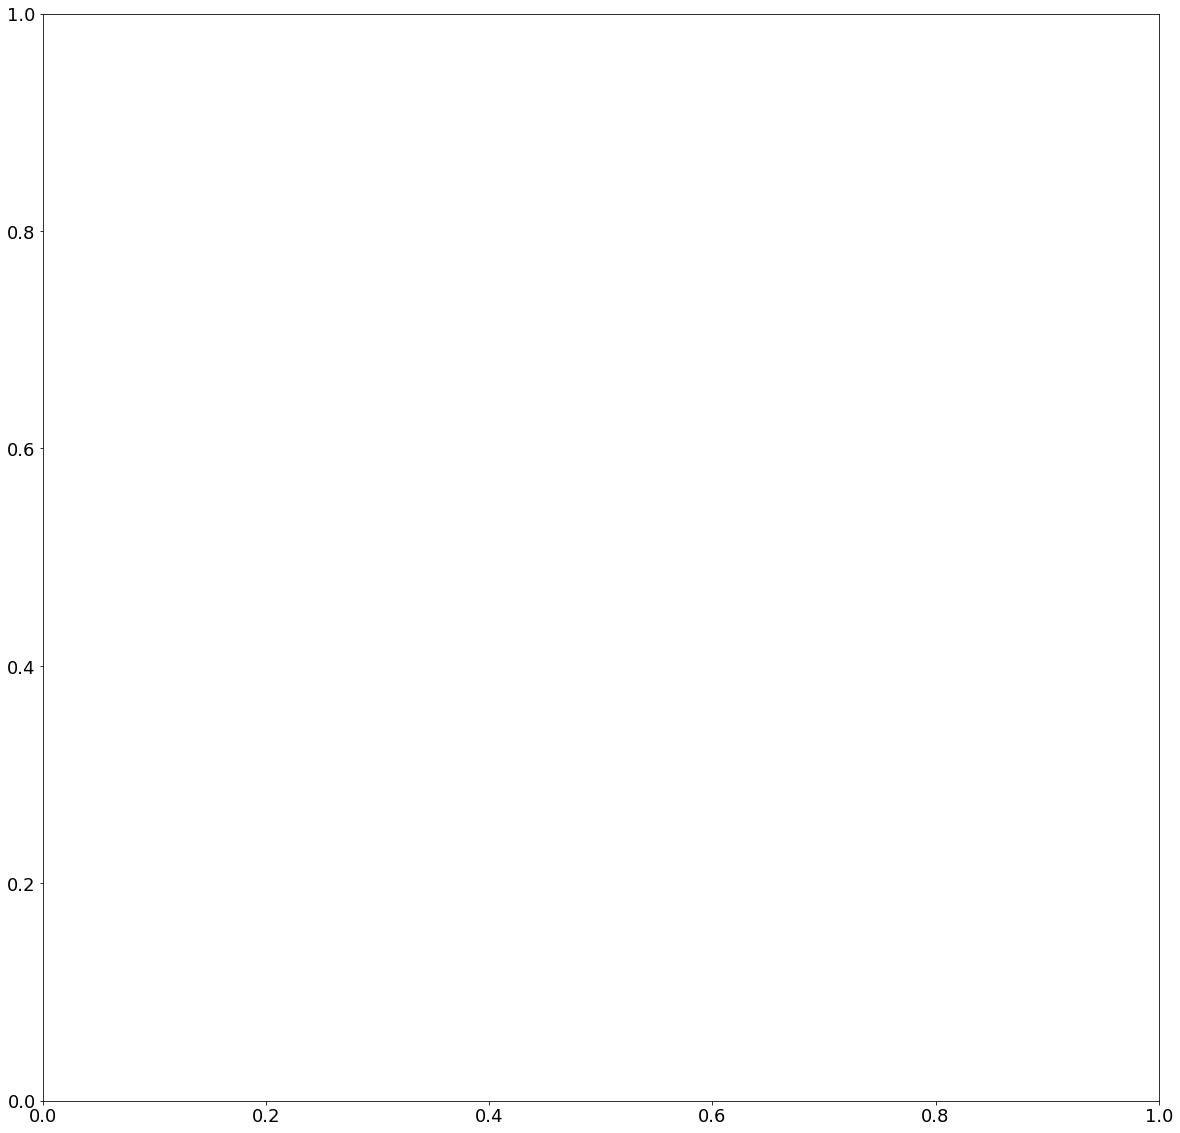

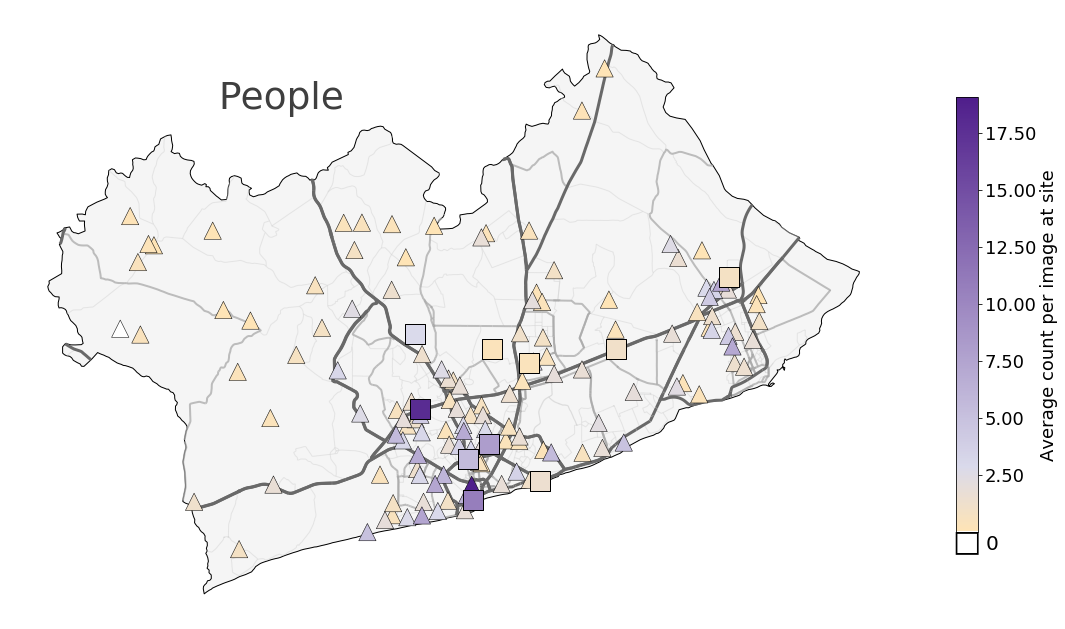

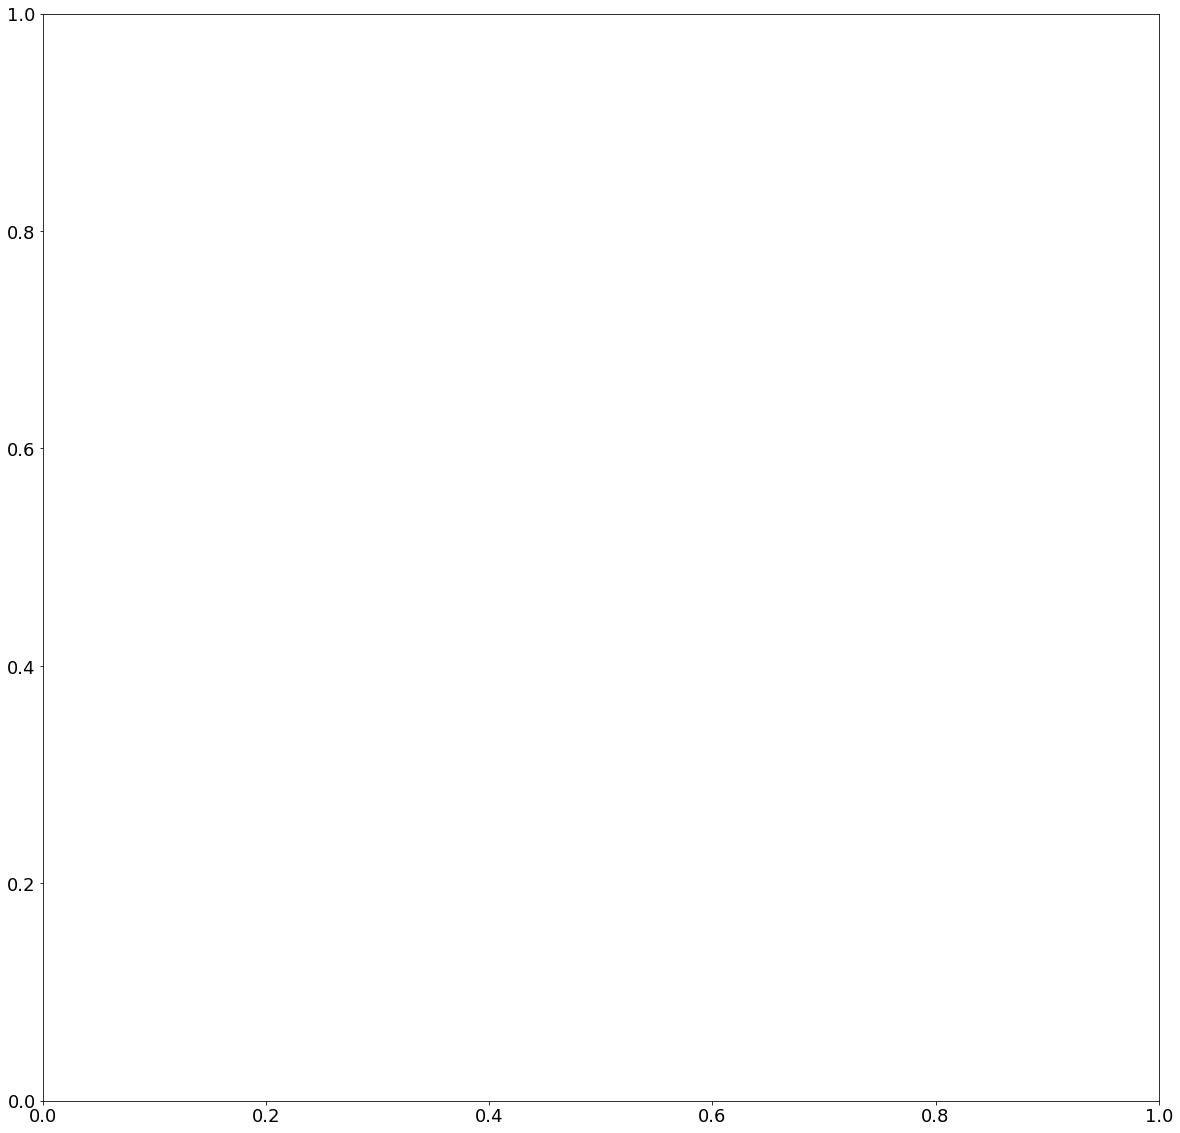

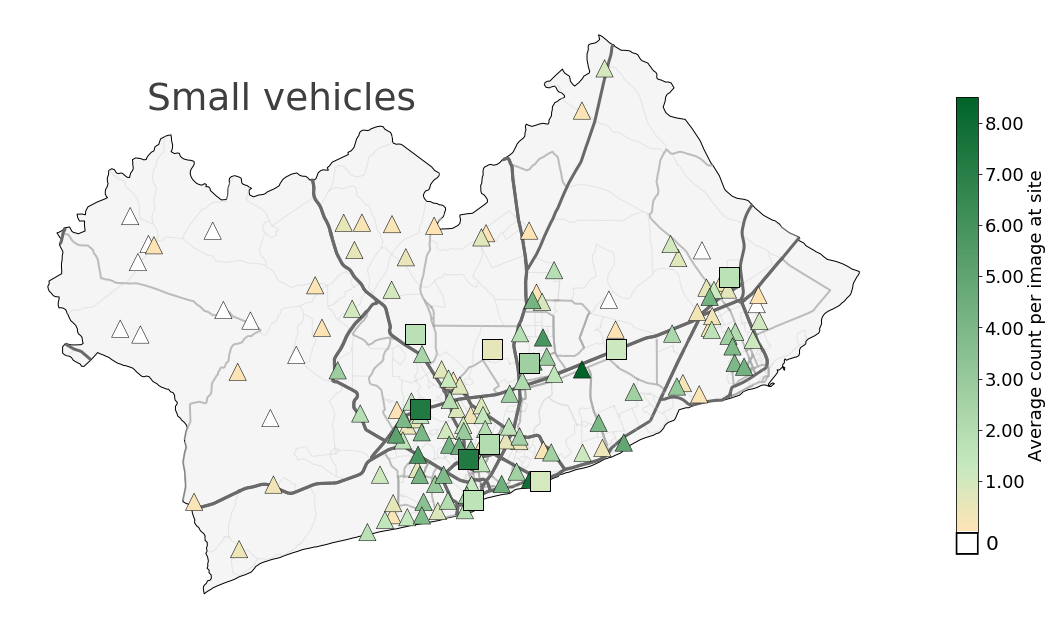

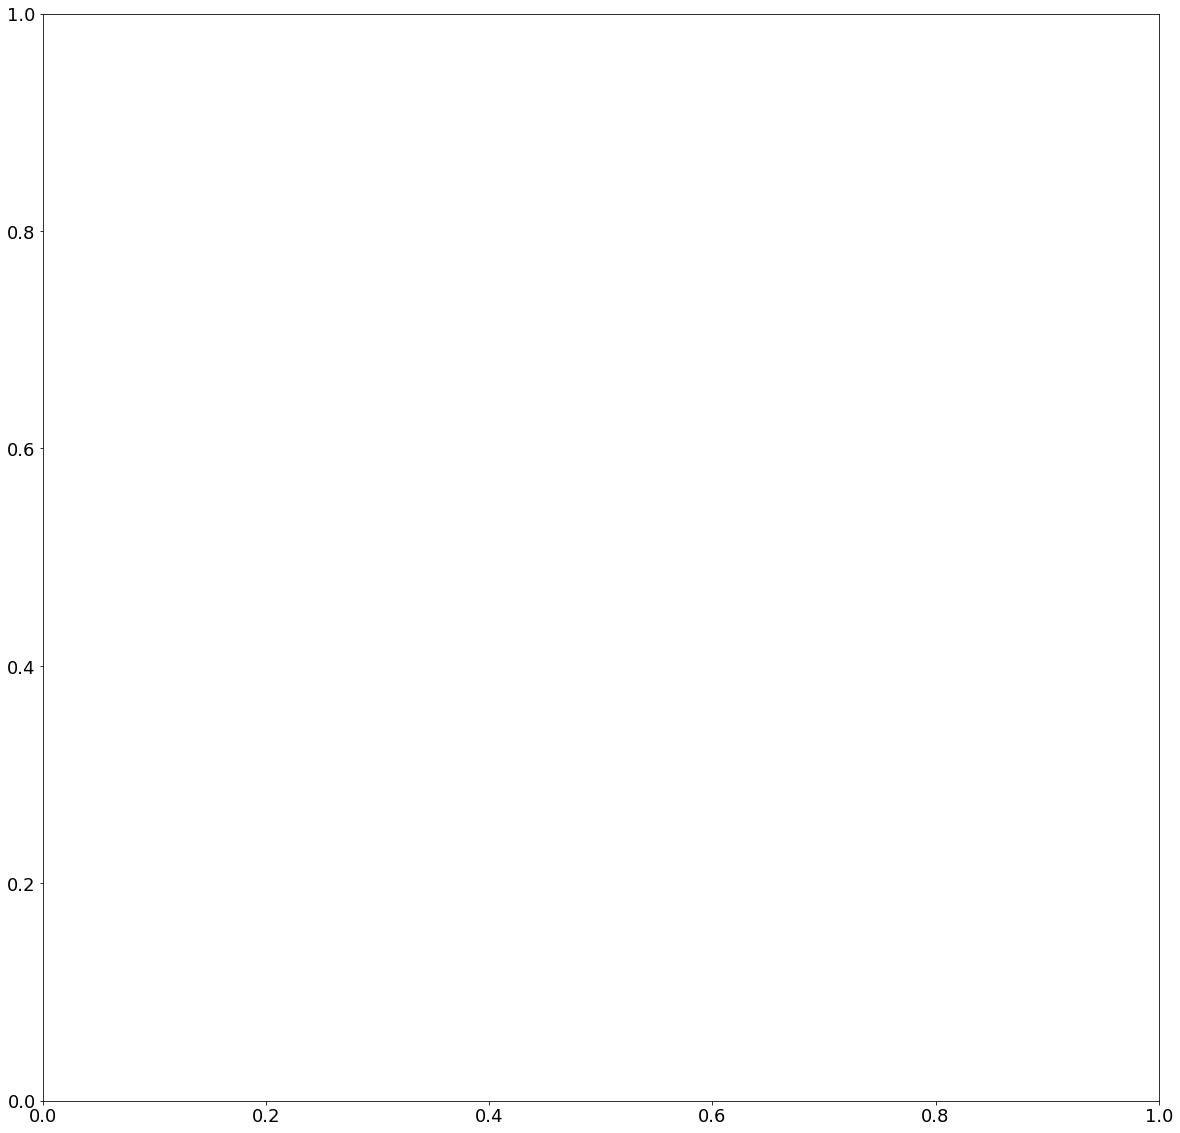

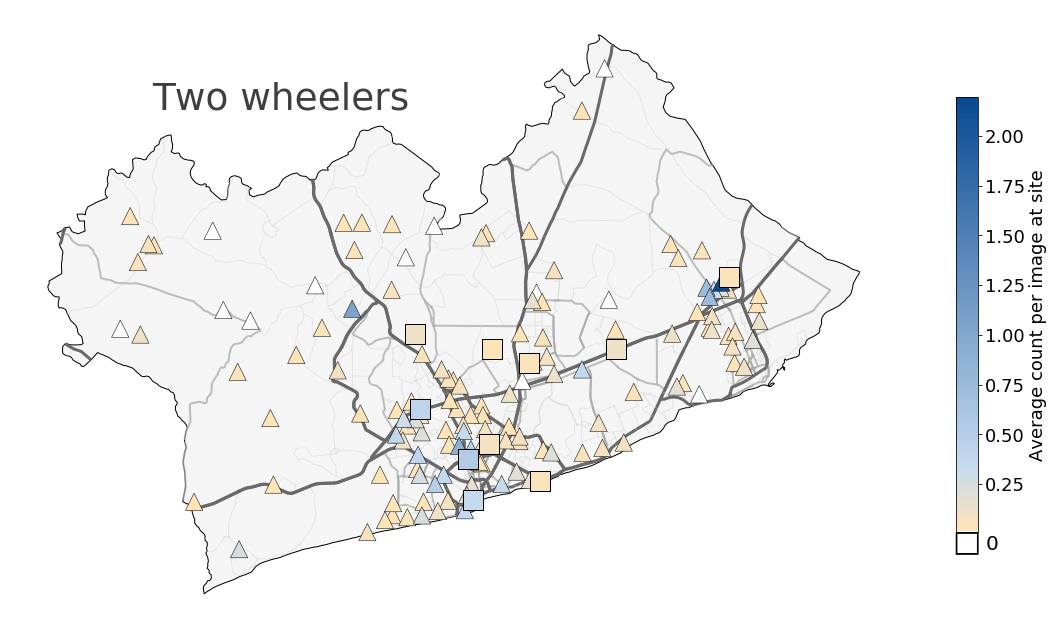

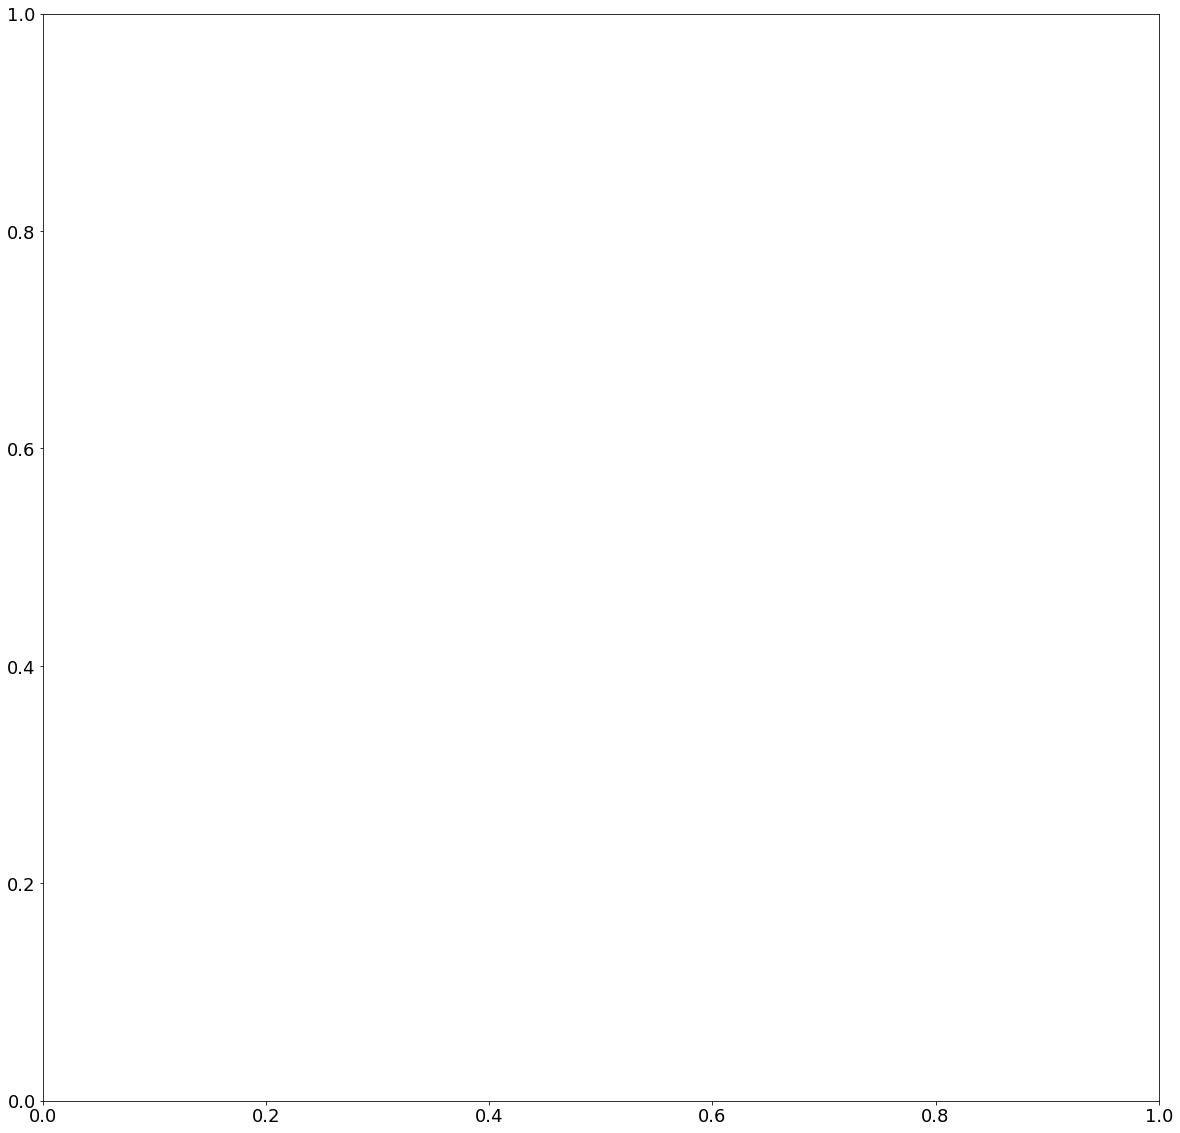

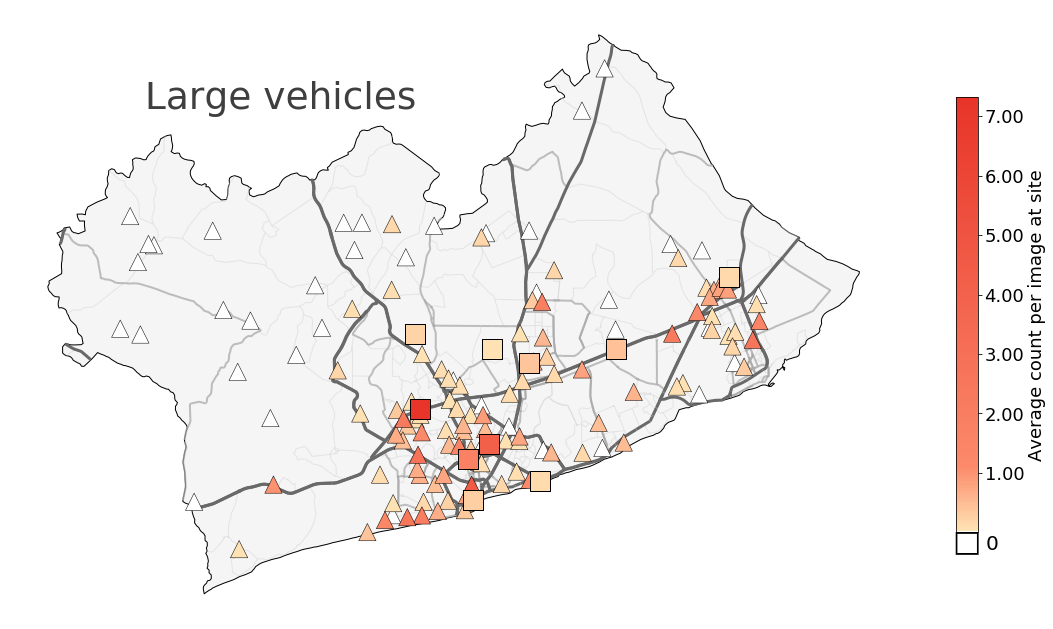

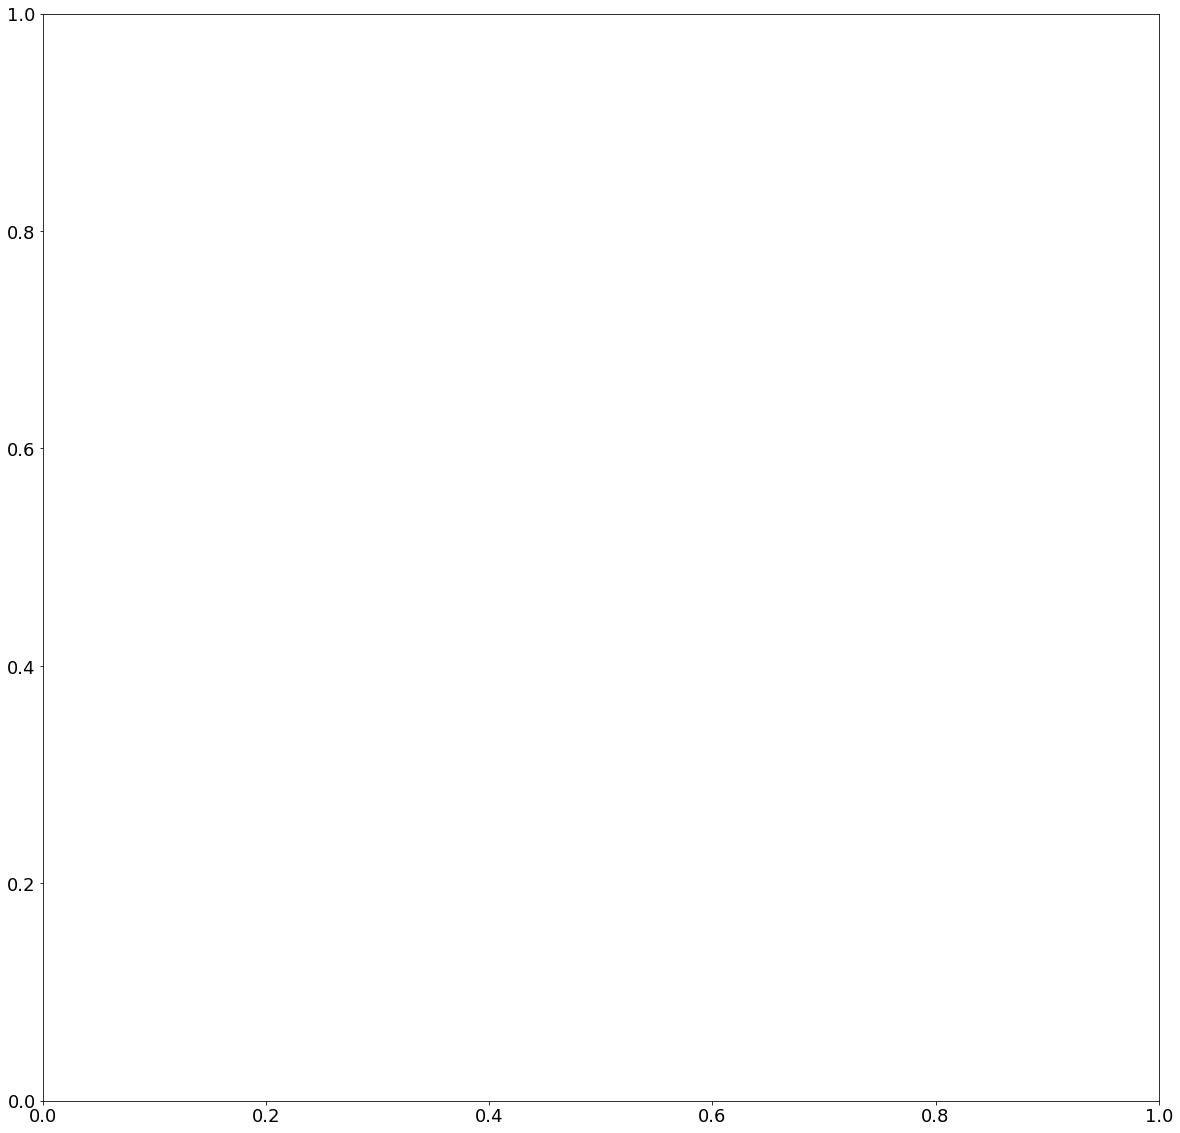

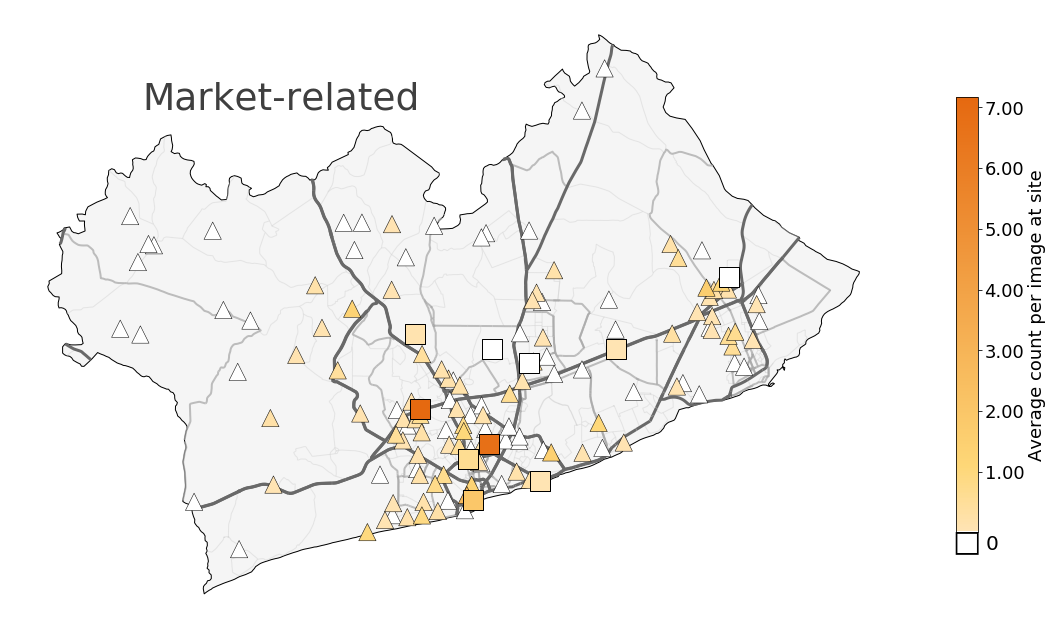

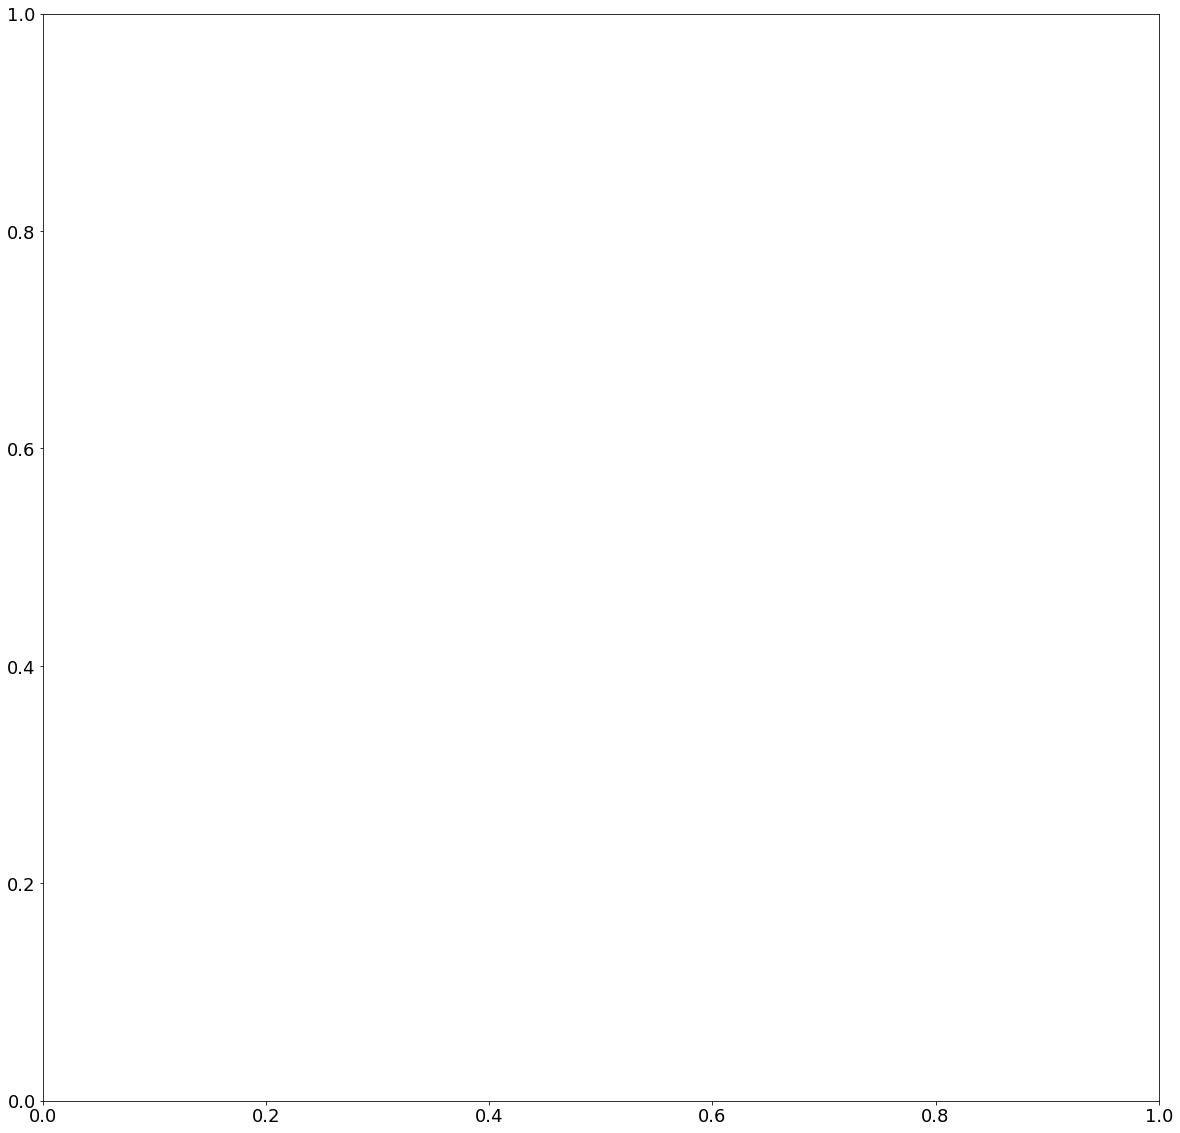

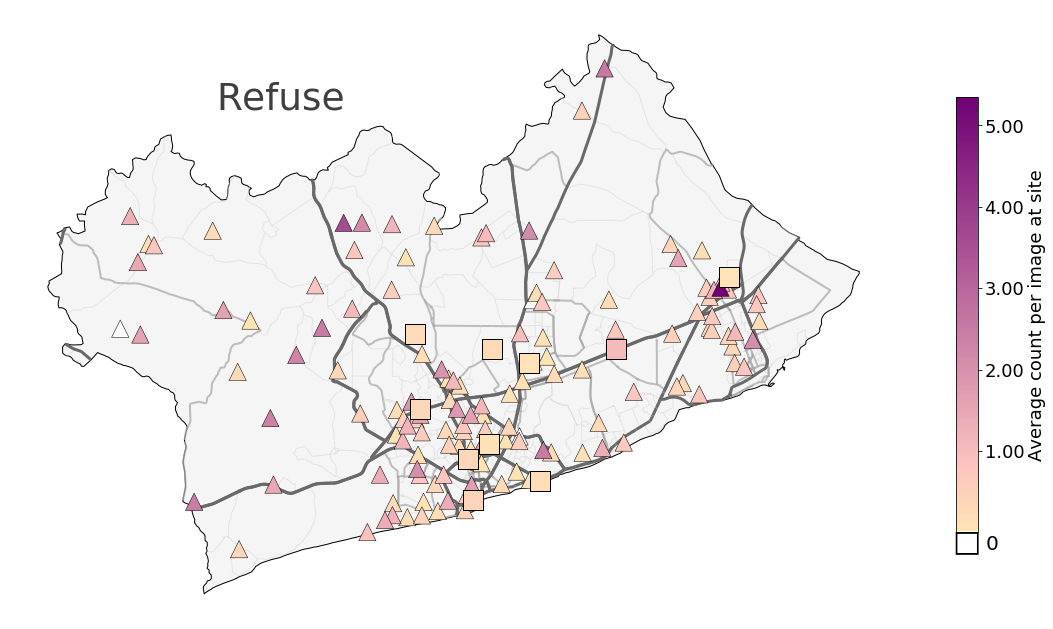

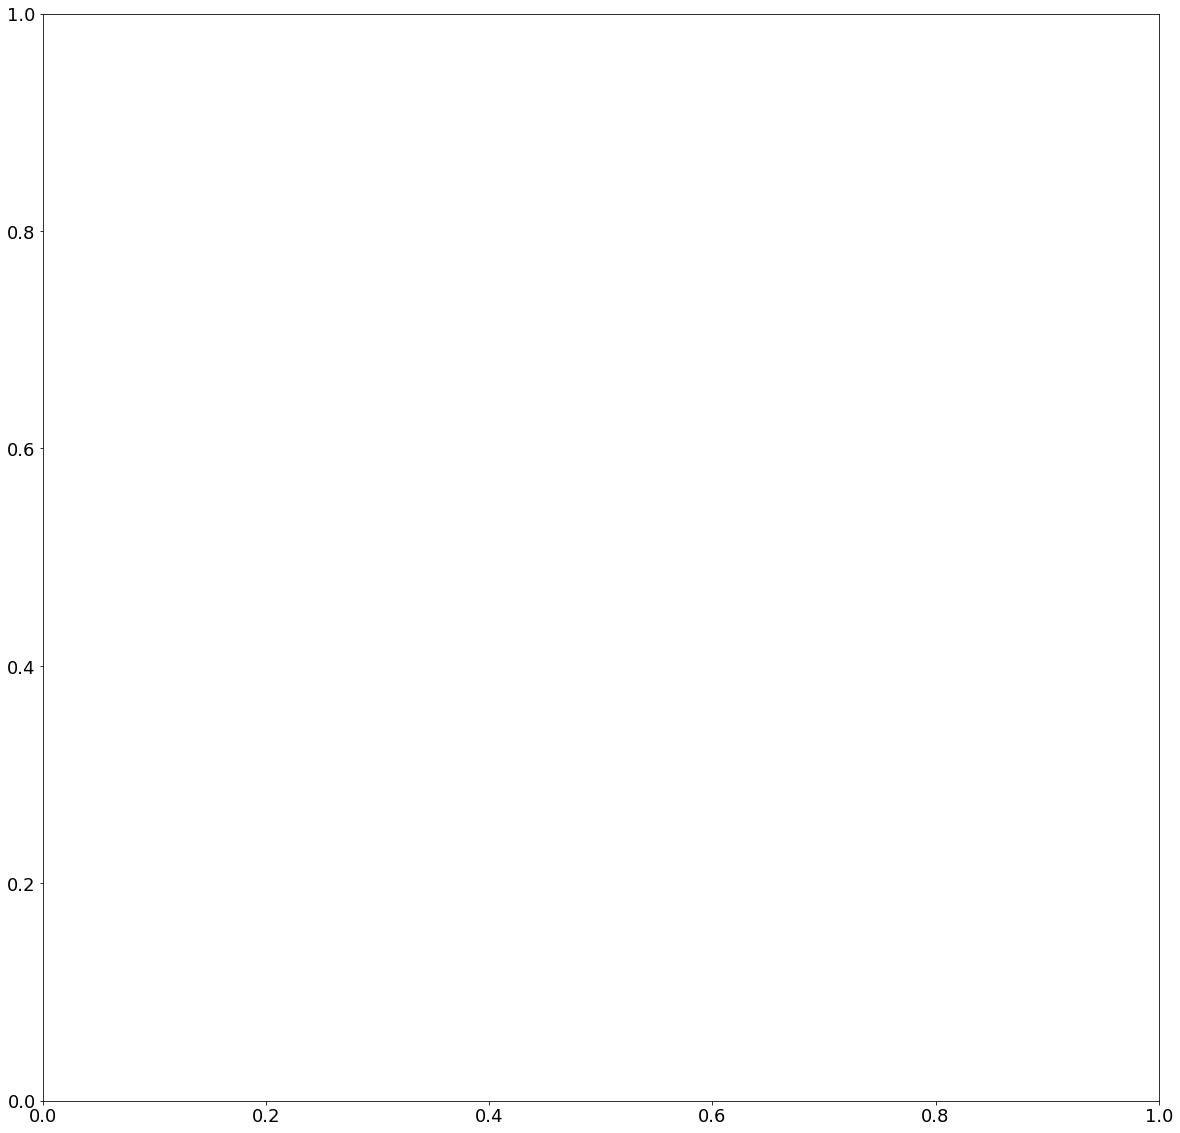

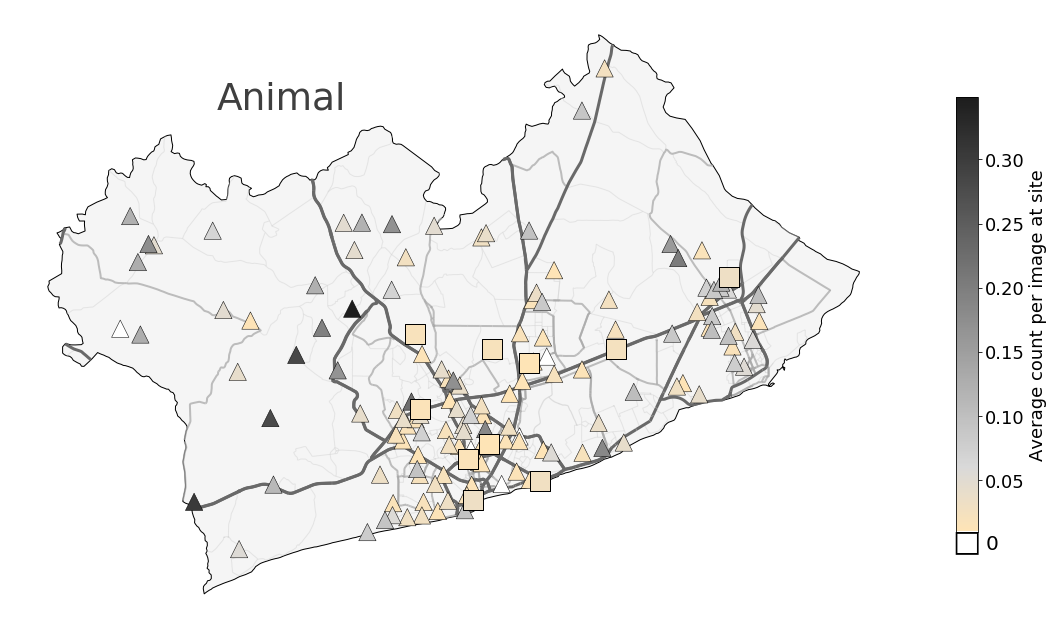

In [52]:
# Plot spatial distribution

import matplotlib.colors as colors
plt.rcParams.update({'font.size': 18})

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

trunk = roads['code'] == 5112 
primary = roads['code'] == 5113
secondary = roads['code'] == 5114
tertiary = roads['code'] == 5115
cycleway = roads['code'] == 5152

color_dict = {}

color_dict['people'] = plt.cm.Purples
color_dict['market'] = plt.cm.YlOrBr
color_dict['small_vehicles'] = plt.cm.Greens
color_dict['two_wheelers'] = plt.cm.Blues
color_dict['animal'] = plt.cm.Greys
color_dict['large_vehicles'] = plt.cm.Reds
color_dict['refuse'] = plt.cm.RdPu

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Function that generates the colorbars for the plot.
def map_cmap(color_dict, obj):

    if obj=='market':
        cmap_trunc = truncate_colormap(color_dict, 0.30, 0.65)
    elif obj=='large_vehicles':
        cmap_trunc = truncate_colormap(color_dict, 0.40, 0.65)
    else:
        cmap_trunc = truncate_colormap(color_dict, 0.25, 0.9)

    cmaplist = [cmap_trunc(i) for i in range(cmap_trunc.N)]

    bar_colors = ["moccasin",cmaplist[0], cmaplist[len(cmaplist)-1]]
    nodes = [0.0,0.15, 1.0]

    cmap_1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, bar_colors)))

    cmaplist = [cmap_1(i) for i in range(cmap_1.N)]
    # force the first color entry to be white
    cmaplist[0] = (1.0, 1.0, 1.0, 1.0)

    bar_colors_2 = ["white","white"]
    nodes_2 = [0.0, 1.0]

    cmap_2 = LinearSegmentedColormap.from_list("mycmap_2", list(zip(nodes_2, bar_colors_2)))

    num_cols = cmap_1.N
    cmap_1 = colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, num_cols)
    
    # combine them and build a new colormap
    N = 1000
    bar_colors = np.vstack((cmap_2(np.linspace(0, 1, (N/10)-1)),
                       cmap_1(np.linspace(0, 1, N))))
    
    new_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', bar_colors)    
    return new_cmap, cmap_1

plot_cats = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse', 'animal']

for obj in plot_cats: 
#for obj in ['people']: 
    new_cmap, cbar_cmap = map_cmap(color_dict[obj], obj)
#     cbar_cmap = cbar_cmap(color_dict[obj], obj)
    
    fig, ax = plt.subplots(figsize=(20,20))    
    ax = acc.to_crs(epsg=4326).plot(facecolor="whitesmoke", edgecolor="black", figsize=(20,20), alpha=1,zorder=1)
    ax.set_axis_off()
    roads[tertiary].to_crs(epsg=4326).plot(figsize=(20,20), ax=ax,zorder=2, linewidth=1, color='lightgrey',alpha=0.5)
    roads[secondary].to_crs(epsg=4326).plot(figsize=(20,20), ax=ax,zorder=3, linewidth=2, color='darkgrey',alpha=0.75)
    roads[trunk | primary].to_crs(epsg=4326).plot(figsize=(20,20), ax=ax,zorder=4, linewidth=3, color='dimgrey',alpha=1)

    obj_max = geo_df[obj+'_norm_counts'].max()
    #geo_df[geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=1, zorder=5, marker="^", column = obj+'_norm_counts',markersize=300,linewidth=0.5,edgecolor='black', cmap=new_cmap, vmin=-obj_max/10,vmax=obj_max,legend=True,legend_kwds={'label': "Average count per image at site",'orientation': "vertical",'shrink': 0.4, 'format': '%.2f'})
    geo_df[geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=1, zorder=5, marker="^", column = obj+'_norm_counts',markersize=300,linewidth=0.5,edgecolor='black', cmap=new_cmap, vmin=-obj_max/10,vmax=obj_max,legend=False)
    geo_df[~geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=1, zorder=6, marker="s", column = obj+'_norm_counts',markersize=400,linewidth=1,edgecolor='black', vmin=-obj_max/10,vmax=obj_max, cmap=new_cmap,legend=False)
    geo_df[geo_df['site'].str.startswith('S')].sort_values(by=obj+'_norm_counts',ascending=True).to_crs(epsg=4326).plot(ax=ax, alpha=0, zorder=7, marker=",", column = obj+'_norm_counts',markersize=0,linewidth=0,edgecolor='black', cmap=cbar_cmap, vmin=0.01,vmax=obj_max,legend=True,legend_kwds={'label': "Average count per image at site",'orientation': "vertical",'shrink': 0.4, 'format': '%.2f'})

    ax.text(-0.35, 5.825, obj.replace('market', 'market-related').capitalize().replace('_',' '), color='black',fontsize='37.5',alpha=0.75,horizontalalignment='center')
    #ax.text(0.1, 5.52, '□ - 0', color='black',fontsize='25',alpha=1,horizontalalignment='center')
    ax.text(0.13925, 5.505, '□', color='black',fontsize='30',alpha=1,horizontalalignment='left')
    ax.text(0.173, 5.505, '0', color='black',fontsize='20',alpha=1,horizontalalignment='right')

    plt.savefig('../results/maps/'+obj+'_med.pdf', format='pdf')

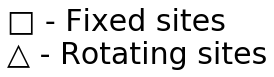

In [38]:
fig, ax = plt.subplots(figsize=(4,1.1))    
ax.set_axis_off()

ax.text(-0.15, 0.1, '□ - Fixed sites\n△ - Rotating sites', color='black',fontsize='30',alpha=1,horizontalalignment='left')
plt.savefig('../results/maps/legend.pdf', format='pdf')

In [29]:
plot_categories = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse', 'animal']

for obj in plot_categories:
    for site in site_cams:
        if(site.lower() != 's'):
            for cam in site_cams[site]:
                object_data[site][cam][obj+"_rank"] = None

In [59]:
# Functions for plotting Range plots

def object_hour_samples(object_data_frame,site_cams_dict, obj):

    trend_cols = ['site_cam','site_type','object','hour','counts_per_hour']

    week_totals = pd.DataFrame(columns=trend_cols)

    for site in site_cams_dict:
        for cam in site_cams_dict[site]:
            if(len(object_data_frame[site][cam]) > 100):
                campaign_bool = np.logical_and(object_data_frame[site][cam].index >= datetime.datetime(2019,4,10), object_data_frame[site][cam].index <= datetime.datetime(2020,6,11))
                lock_bool = np.logical_or(object_data_frame[site][cam].index <= datetime.datetime(2020,3,30), object_data_frame[site][cam].index >= datetime.datetime(2020,4,20))
                date_bool = np.logical_and(campaign_bool,lock_bool)
                if(site in site_cams_dict):
                    if(site.lower()[0] != 's'):
                        if(object_data_frame[site][site_cams[site][0]]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][site_cams[site][0]]['site_type'][0]
                    else:
                        if(object_data_frame[site][cam]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][cam]['site_type'][0]
                else:
                    site_type = object_data_frame[site][cam]['site_type'][0]
                    
                WB_cat = object_data_frame[site][cam]['WB_cat'][0]
                pop_dens_cat = object_data_frame[site][cam]['pop_dens_cat'][0]
                ndvi_cat = object_data_frame[site][cam]['ndvi_cat'][0]
                road_surface = object_data_frame[site][cam]['road_surface'][0]
                road_type = object_data_frame[site][cam]['road_type'] [0]
                
                if(site.lower()[0] != 's' and len(object_data[site][cam][date_bool]) > 2016):
                    object_data_frame[site][cam][date_bool][obj+"_rank"] = object_data_frame[site][cam][date_bool][obj+'_counts'].astype(int).rank(method='first')
                    hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == 0]
                    sample_rate = 84
                    #sample_rate = len(hour_df) 
                    #sample_rate = max(len(hour_df)/12,84)
                    sample_df = hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]]

                    for i in range(1,24):
                        hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == i]
                        sample_rate = 84
                        #sample_rate = len(hour_df) 
                        #sample_rate = max(len(hour_df)/12,84) 
                        sample_df=sample_df.append(hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]])
                else:
                    sample_df = object_data_frame[site][cam][date_bool]
                        
                site_frame = pd.DataFrame(columns=trend_cols, index=sample_df.index)
                site_frame['counts_per_hour'] = sample_df[obj+'_counts'].astype(float)
                site_frame['hour'] = sample_df.index.hour.astype(int)
                site_frame['site_cam'] = site+'_'+cam
                site_frame['site_type'] = site_type
                site_frame['ndvi_cat'] = ndvi_cat
                site_frame['pop_dens_cat'] = pop_dens_cat
                site_frame['WB_cat'] = WB_cat
                site_frame['road_type'] = road_type               
                site_frame['object'] = obj
                week_totals = week_totals.append(site_frame).sort_index()

    week_totals.reset_index(inplace=True)
    return week_totals

def object_hour_lockdown(object_data_frame,site_cams_dict, obj, lockdown):

    trend_cols = ['site_cam','site_type','object','hour','counts_per_hour']

    week_totals = pd.DataFrame(columns=trend_cols)
    
    site_bools={'other', 'low-dens', 'high-dens'}
    for site in site_cams_dict:
        for cam in site_cams_dict[site]:
            lock_bool = np.logical_and(object_data_frame[site][cam].index >= datetime.datetime(2020,3,30), object_data_frame[site][cam].index <= datetime.datetime(2020,4,20))
            if(len(object_data_frame[site][cam][lock_bool]) > 100):
                if(lockdown == 'lockdown'):
                    date_bool = lock_bool
                elif(lockdown == 'post_lockdown'):
                    date_bool = object_data_frame[site][cam].index >= datetime.datetime(2020,4,20)
                else:
                    date_bool = np.logical_and(object_data_frame[site][cam].index >= datetime.datetime(2019,4,10), object_data_frame[site][cam].index <= datetime.datetime(2020,3,30))
                if(site in site_cams_dict):
                    if(site.lower()[0] != 's'):
                        if(object_data_frame[site][site_cams[site][0]]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][site_cams[site][0]]['site_type'][0]
                    else:
                        if(object_data_frame[site][cam]['site_type'][0] == 'traffic'):
                            site_type = 'commercial'
                        else:
                            site_type = object_data_frame[site][cam]['site_type'][0]
                else:
                    site_type = object_data_frame[site][cam]['site_type'][0]
                    
                WB_cat = object_data_frame[site][cam]['WB_cat'][0]
                pop_dens_cat = object_data_frame[site][cam]['pop_dens_cat'][0]
                ndvi_cat = object_data_frame[site][cam]['ndvi_cat'][0]
                road_surface = object_data_frame[site][cam]['road_surface'][0]
                road_type = object_data_frame[site][cam]['road_type'] [0]
                
                if(site.lower()[0] != 's' and len(object_data[site][cam][date_bool]) > 2016):
                    object_data_frame[site][cam][date_bool][obj+"_rank"] = object_data_frame[site][cam][date_bool][obj+'_counts'].astype(int).rank(method='first')
                    hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == 0]
                    sample_rate = 84
                    sample_df = hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]]

                    for i in range(1,24):
                        hour_df = object_data_frame[site][cam][date_bool][object_data_frame[site][cam][date_bool].index.hour == i]
                        sample_rate = 84
                        sample_df=sample_df.append(hour_df.sort_values(by=obj+"_rank").iloc[[i for i in range(0,len(hour_df),int(len(hour_df)/(sample_rate)))]+[len(hour_df)-1]])
                else:
                    sample_df = object_data_frame[site][cam][date_bool]
                    
                site_frame = pd.DataFrame(columns=trend_cols, index=sample_df.index)
                site_frame['counts_per_hour'] = sample_df[obj+'_counts'].astype(float)
                site_frame['hour'] = sample_df.index.hour.astype(int)
                site_frame['site_cam'] = site+'_'+cam
                site_frame['site_type'] = site_type
                site_frame['ndvi_cat'] = ndvi_cat
                site_frame['pop_dens_cat'] = pop_dens_cat
                site_frame['WB_cat'] = WB_cat
                site_frame['road_type'] = road_type                
                site_frame['object'] = obj
                week_totals = week_totals.append(site_frame).sort_index()

    week_totals.reset_index(inplace=True)
    return week_totals

['Medium/low-density\nResidential', 'High-density\nresidental', 'Commercial/business/\nindustrial', 'Peri-urban background']
people


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


small_vehicles


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


two_wheelers


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


large_vehicles


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


market


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


refuse


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


animal


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


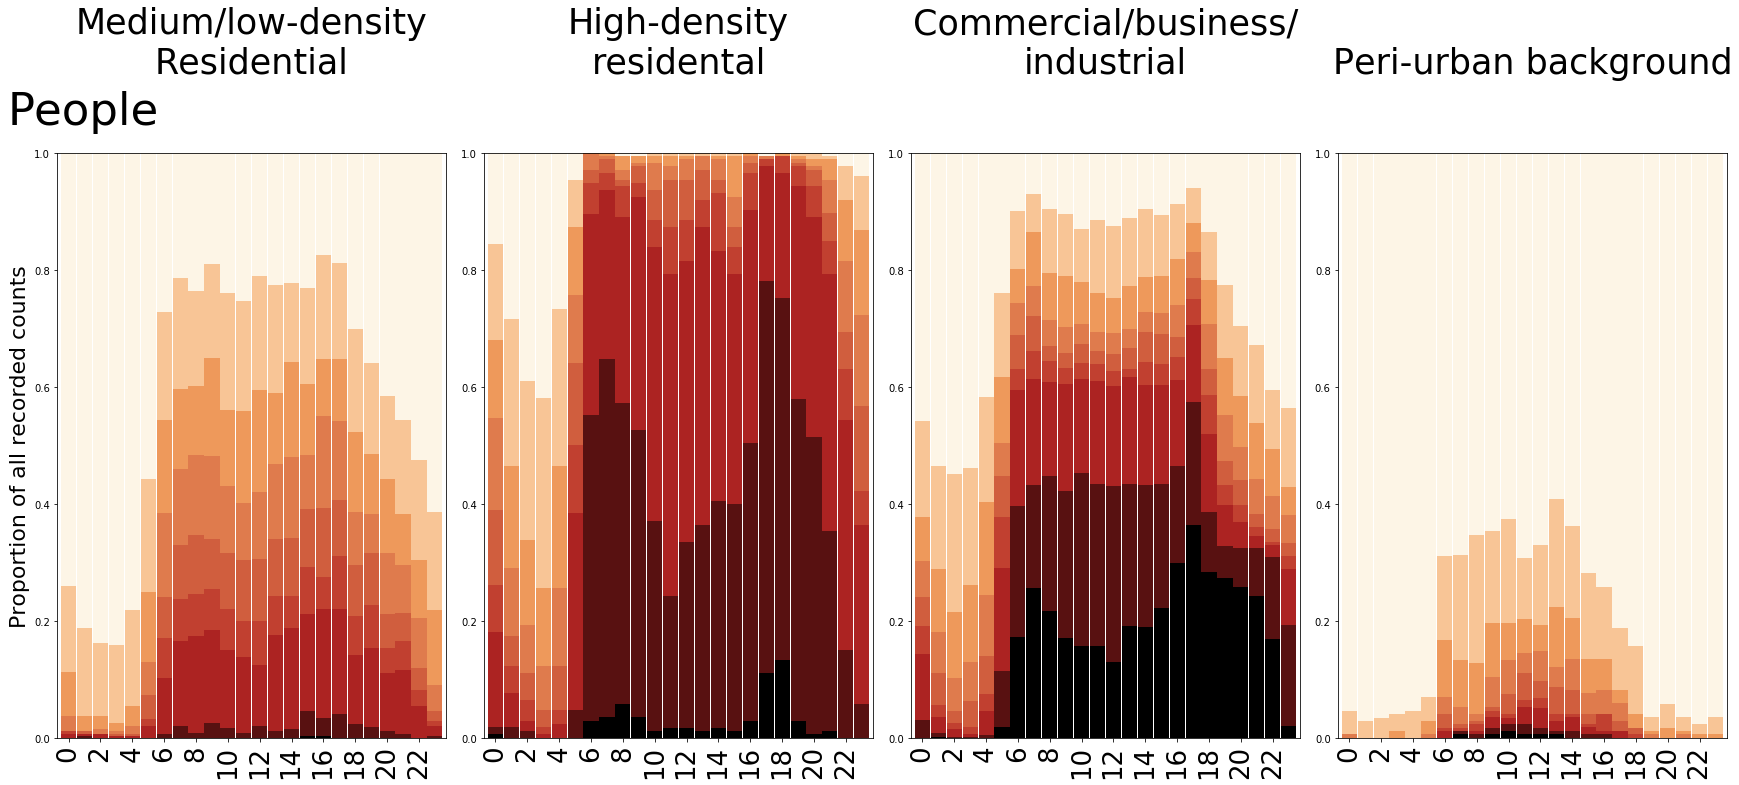

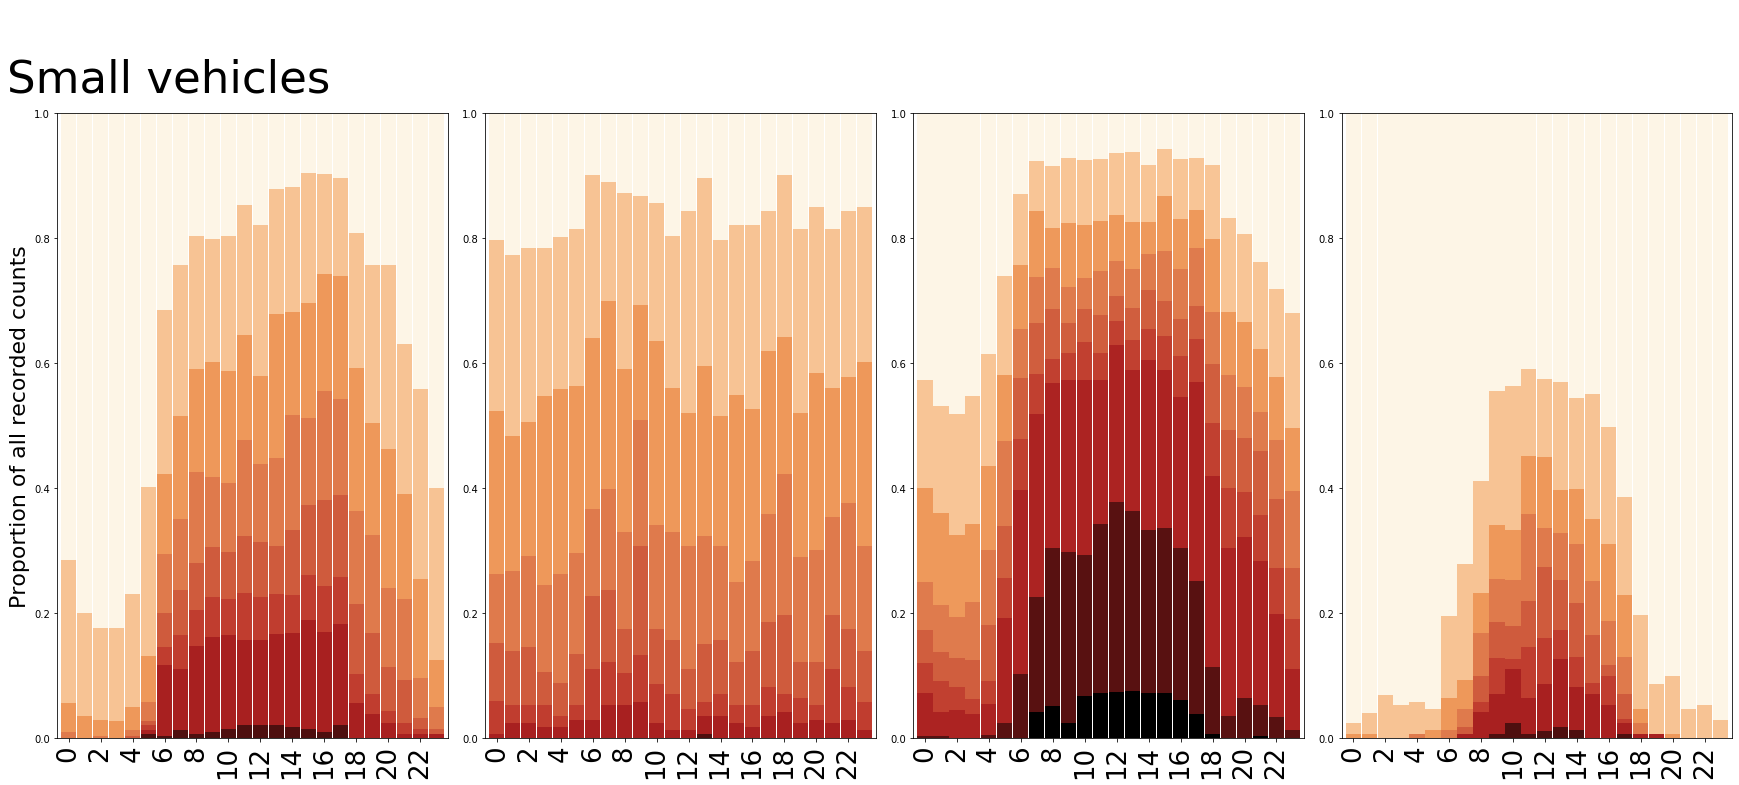

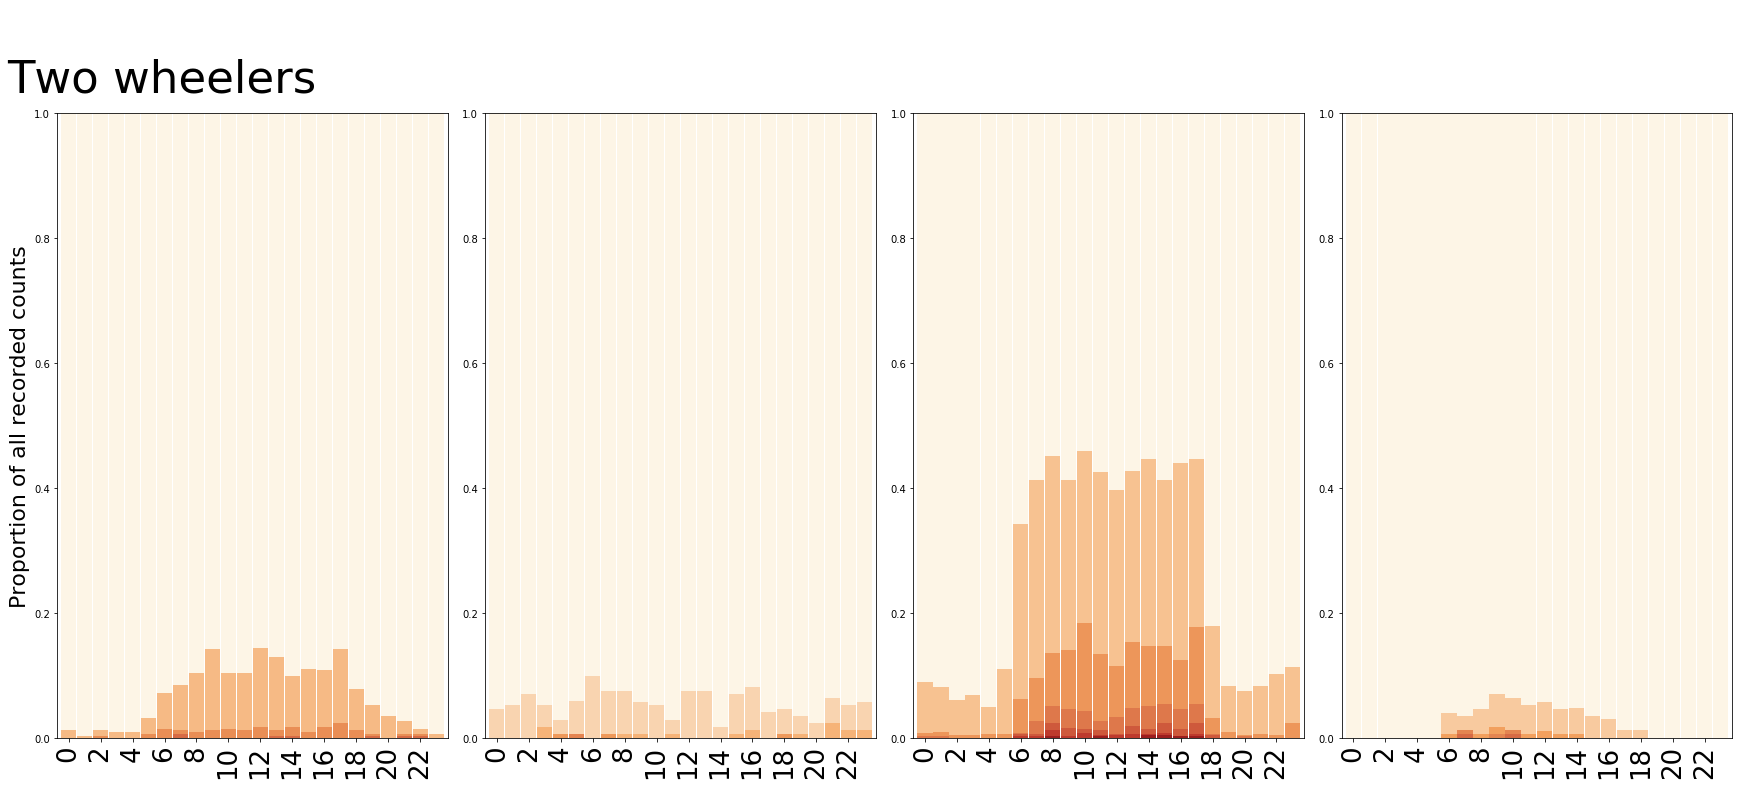

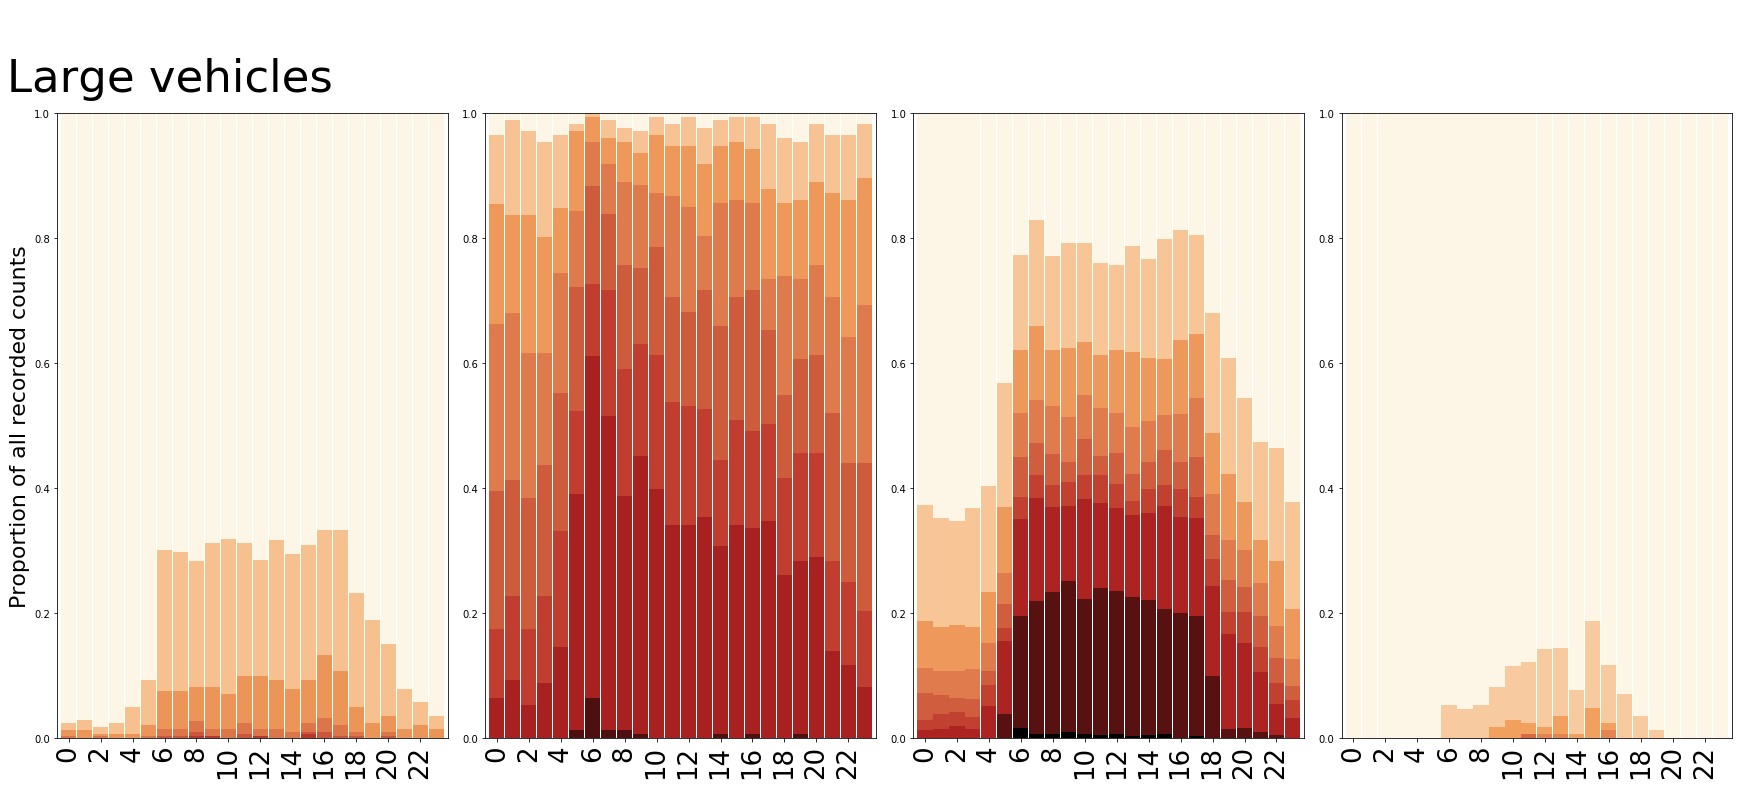

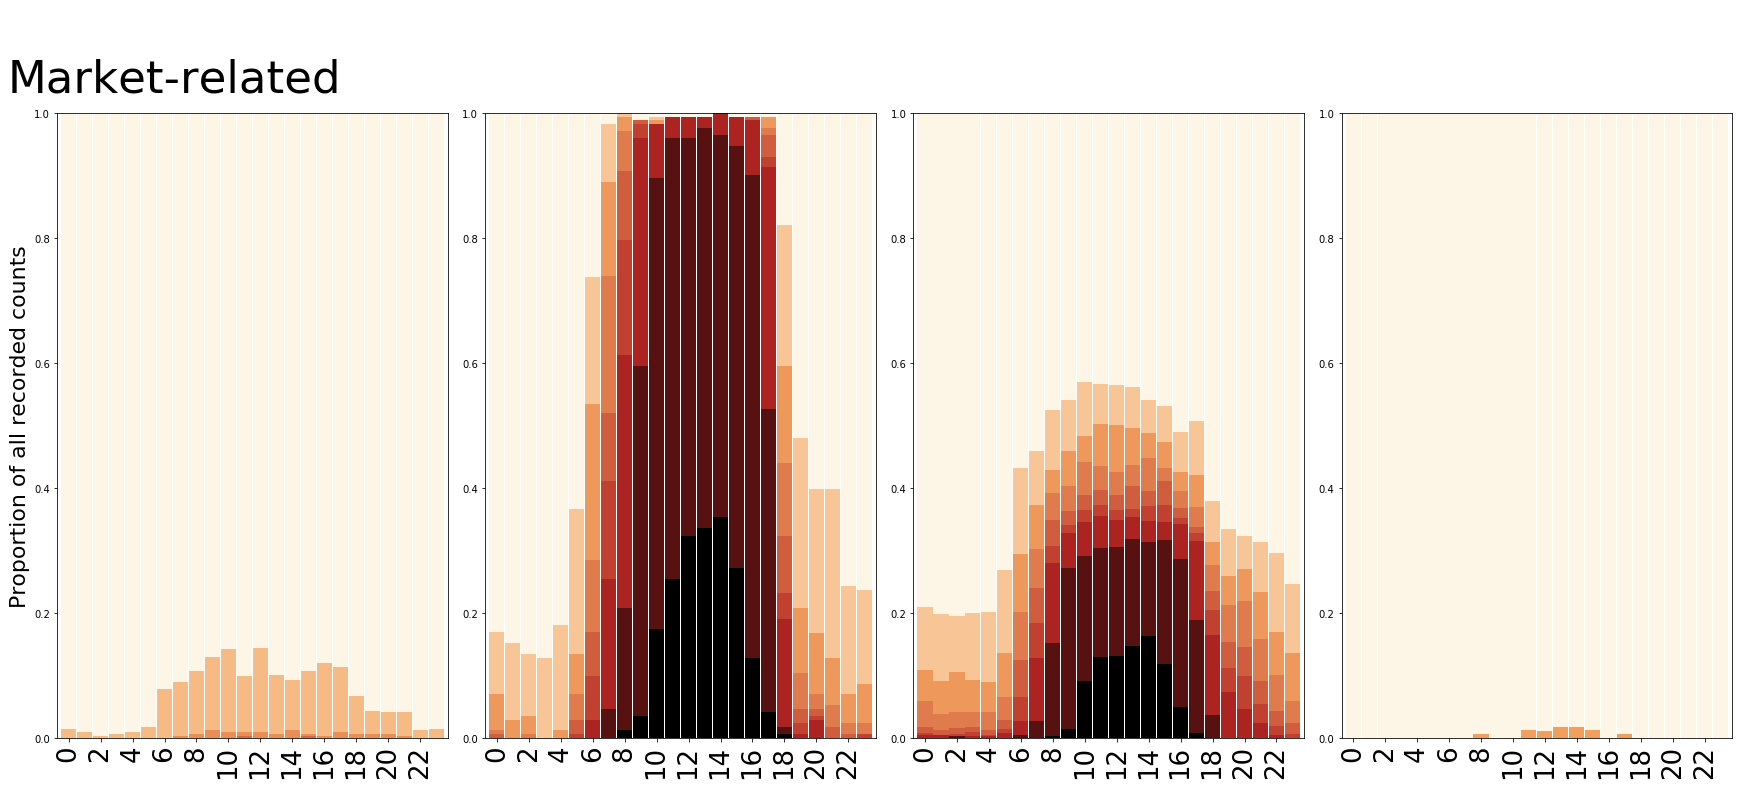

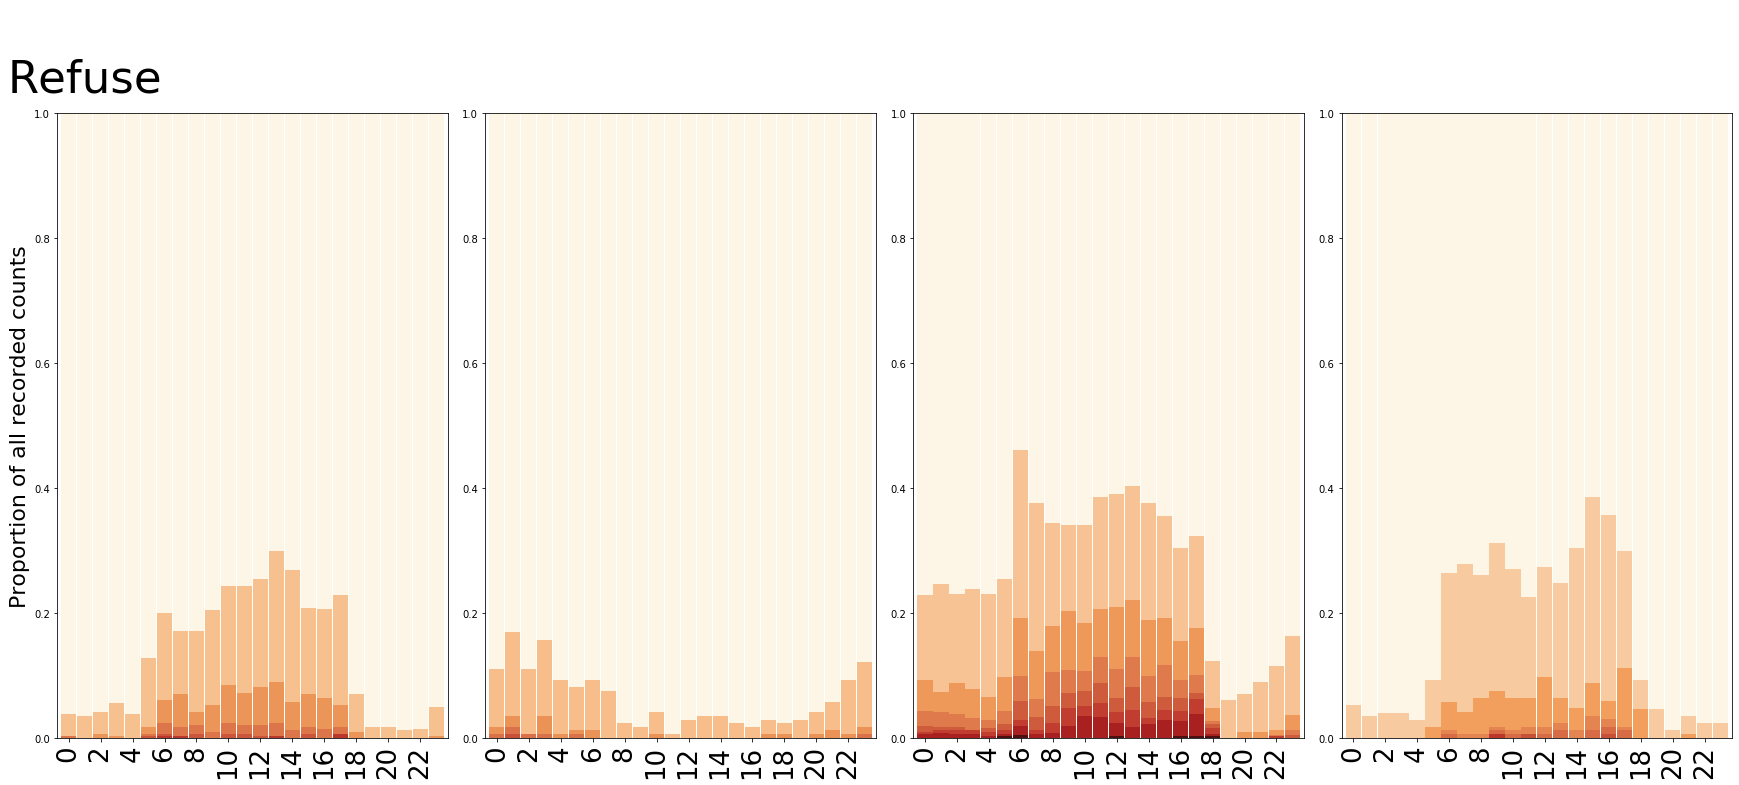

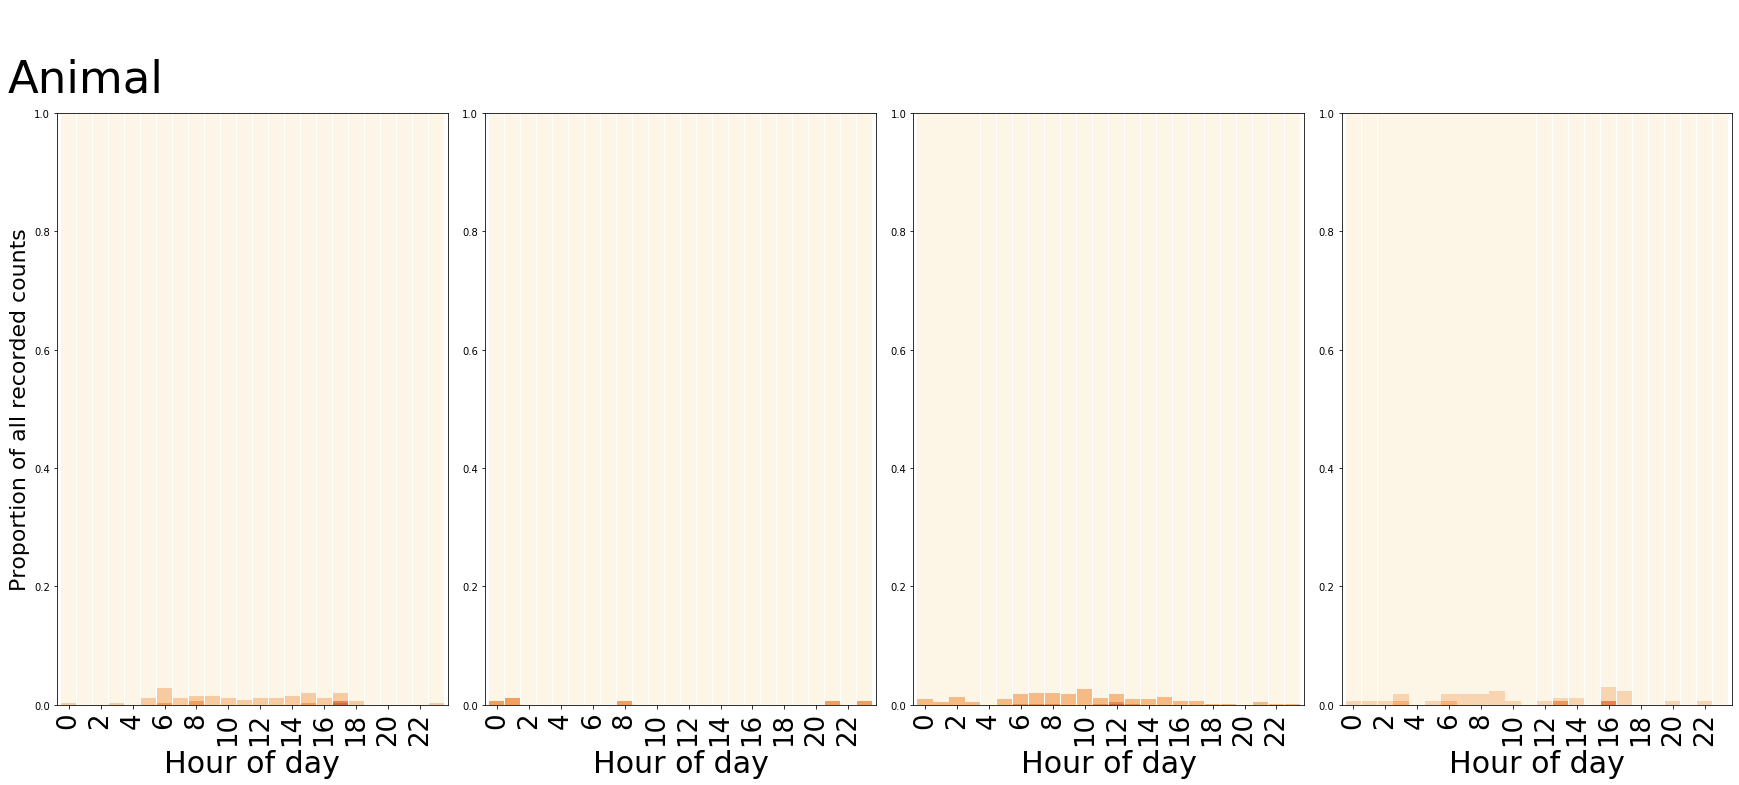

In [61]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import matplotlib.colors as mcolors
plt.rcParams['legend.title_fontsize'] = 'large'

def simpleaxis(ax):
    ax.spines['bottom'].set_visible(False)    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_top()

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


plot_colors = ["black", "firebrick", "sandybrown", "oldlace"]
nodes = [0.0, 0.25, 0.8, 1.0]
    
cmap_range = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, plot_colors)))

#plot_categories = ['car', 'person', 'trotro', 'stall', 'truck', 'motorcycle', 'lorry', 'umbrella', 'trash', 'taxi', 'van', 'debris', 'bowl', 'food', 'animal', 'bicycle']
plot_categories = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse', 'animal']#,'paratransit']

quantiles = [0,0.25,0.5,0.75,0.875,0.9375,0.96875,1.0]
bins = [0.5,1.5,2.5,3.5,4.5,5.5,10.5,20.5,80.5]

#q_labels = ['Low', 'Low-med', 'Med-high', 'High', 'V. High', 'V.V. High', 'V.V.V High']
q_labels = ['1 count', '2 counts', '3 counts', '4 counts', '5 counts', '6-10 counts', '11-20 counts', '21+ counts']

# Field Team Classifications
site_labels = ['Medium/low-density\nResidential','High-density\nresidental','Commercial/business/\nindustrial','Peri-urban background']

## Lots of different ways to split the sites up for plotting.
#World Bank Classifications
#site_labels = ['Formal Residental','Informal Residential','Commercial','Less Built Up']

#NDVI Classifications
#site_labels = ['NDVI Quintile '+str(i) for i in range(1,6)]

#Pop_dens Classifications
#site_labels = ['Pop. Density Quintile '+str(i) for i in range(1,6)]

#Road types
#site_labels = ['Minor Roads','Medium Roads','Major Roads']

#Road surfaces
#site_labels = ['Dirt Roads', 'Asphalt Roads', 'Mixed Roads']

print(site_labels)

# Uncomment to produce lockdown comparisons
lockdown='pre_lockdown'

for obj in plot_categories[:]:
#for obj in ['people']:
    print(obj)
    week_totals = object_hour_lockdown(object_data,site_cams,obj,lockdown)
    #week_totals = object_hour_samples(object_data,site_cams,obj)

    if(obj in ['people','two_wheelers']):
        fig, ax = plt.subplots(1,len(site_labels),figsize=(24,9*(1.2)), constrained_layout=True)
    elif(obj == 'animal','market'):
        fig, ax = plt.subplots(1,len(site_labels),figsize=(24,9*(1.2)), constrained_layout=True)
    else:
        fig, ax = plt.subplots(1,len(site_labels),figsize=(24,9), constrained_layout=True)
    
    # ONLY uncomment if you want to produce a Legend figure (and uncomment further down)
    #figlegend = plt.figure(figsize=(24,9))   
    
    obj_count_bool = np.logical_and(week_totals.counts_per_hour.astype(float) != 0, week_totals.object == obj)

    week_totals['count_category'] = pd.cut(week_totals[obj_count_bool].counts_per_hour.astype(float), bins, labels=q_labels)
    week_totals['count_category'] = week_totals['count_category'].replace(np.nan, 'Zero')

    leg_labels = q_labels

    cat_type = week_totals.site_type
    site_cats=['low-dens', 'high-dens', 'commercial', 'other']

#     cat_type = week_totals.WB_cat
#    site_cats =[1,2,3,4]

#     cat_type = week_totals.ndvi_cat
#     site_cats =['low','low-med','med','med-high','high']

#     cat_type = week_totals.pop_dens_cat
#     site_cats =['low','low-med','med','med-high','high']

#     cat_type = week_totals.road_type
#     site_cats =['minor','medium','major']

#     cat_type = week_totals.road_surface
#     site_cats =['dirt','asphalt','mixed']

    for i,site_type in enumerate(site_cats):
        cat_max = week_totals[np.logical_and(week_totals.object == obj, cat_type == site_type)].groupby(week_totals['hour'].astype(int))['count_category'].nunique().max()
        stack_plot = week_totals[np.logical_and(week_totals.object == obj, cat_type == site_type)].groupby(week_totals['hour'].astype(int))['count_category'].value_counts(normalize=True).unstack()
        stack_plot.columns = pd.CategoricalIndex(stack_plot.columns.values, 
                                         ordered=True, 
                                         categories=list(reversed(q_labels))+["Zero"])
        # Sort the columns (axis=1) by the new categorical ordering
        stack_plot = stack_plot.sort_index(axis=1)   
        cmap_1 = truncate_colormap(cmap_range, 1-float(cat_max/9), 1)    

        if(i == 0):
            range_plot = stack_plot.plot.bar(stacked=True,ax=ax[i], rot=0, width=0.95, cmap=cmap_1, legend=None)
            ax[i].set_ylabel('Proportion of all recorded counts', fontsize=22)
        else:
            range_plot = stack_plot.plot.bar(stacked=True,ax=ax[i], rot=0, width=0.95, cmap=cmap_1, legend=None)        

        _, labels = ax[i].get_legend_handles_labels()

        if(len(labels) == 9):
              handles, labels = ax[i].get_legend_handles_labels() 
                
        ax[i].set_ylim(0,1)
        
        offset = 0
        #if(obj in ['people','two_wheelers']):
        if(obj in ['people']):
        #if(obj in plot_categories):
            ax[i].set_title(site_labels[i], fontsize=35,pad=80)
            #offset = (11/60)
            offset = (1/6)
        else:
            ax[i].set_title(" ", fontsize=35,pad=80)
            #offset = (11/60)
            offset = (1/8)

        #if(obj in ['market','animal']):
        if(obj in ['animal']):
        #if(obj in plot_categories):
            x_tics = range(0,24,2)
            ax[i].set_xticks(x_tics)
            ax[i].set_xticklabels([str(n) for n in x_tics], rotation=90)
            ax[i].tick_params(axis='x', which='major', labelsize=26)
            ax[i].set_xlabel('Hour of day', fontsize=30)
        else:
            x_tics = range(0,24,2)
            ax[i].set_xticks(x_tics)
            ax[i].set_xticklabels([str(n) for n in x_tics], rotation=90)
            ax[i].tick_params(axis='x', which='major', labelsize=26)
            ax[i].xaxis.label.set_visible(False)

            
## Uncomment if you're producing a figure legend
#    lg = figlegend.legend(handles[::-1], ["Zero"]+q_labels, title= 'Categories of \nnon-zero counts and zeros', loc='center', fontsize = 35, ncol=3)
#    lg.get_title().set_fontsize(25)
#    figlegend.savefig('../results/range_plots/legend.pdf',edgecolor="#ffffff")#, bbox_inches='tight',edgecolor="#000000")

## Used to create the headings for the lockdown plots
#     plt.figtext(0, 0, lockdown.replace("_","-").capitalize(), color='black',fontsize='45',alpha=1,horizontalalignment='left', verticalalignment='bottom')
#     figlegend.savefig('../results/range_plots/lockdown/'+lockdown+'_text.pdf',edgecolor="#ffffff", bbox_inches='tight')

    plt.figtext(0, 1-offset, obj.replace("market","market-related").capitalize().replace("_"," "), color='black',fontsize='45',alpha=1,horizontalalignment='left', verticalalignment='bottom')

    #plt.savefig('../results/range_plots/'+obj+'.pdf',edgecolor="#ffffff", bbox_inches='tight')
    plt.savefig('../results/range_plots/lockdown/'+obj+'_'+lockdown+'.pdf',edgecolor="#ffffff", bbox_inches='tight')

In [38]:
# Work out periods of time during which both cameras at a site were in operation by merging both available cameras.

for site in site_cams:
    if(site[0].lower() == 's'):
        if(len(site_cams[site]) == 1):
            date_bool = np.logical_and(object_data[site][site_cams[site][0]].index >= datetime.datetime(2019,4,10), object_data[site][site_cams[site][0]].index <= datetime.datetime(2020,6,11))
            object_data[site]['total'] = object_data[site][site_cams[site][0]][date_bool].sort_index()
        elif(len(site_cams[site]) == 2):
            date_bool_1 = np.logical_and(object_data[site][site_cams[site][0]].index >= datetime.datetime(2019,4,10), object_data[site][site_cams[site][0]].index <= datetime.datetime(2020,6,11))
            date_bool_2 = np.logical_and(object_data[site][site_cams[site][1]].index >= datetime.datetime(2019,4,10), object_data[site][site_cams[site][1]].index <= datetime.datetime(2020,6,11))

            object_data[site]['total'] = pd.merge_asof(object_data[site][site_cams[site][0]][date_bool_1].sort_index(), object_data[site][site_cams[site][1]][date_bool_2].sort_index(),
                          direction='nearest', on='datetime', tolerance=pd.Timedelta('5m'), suffixes=("_"+site_cams[site][0], "_"+site_cams[site][1])).dropna(axis=0,subset = ['person_counts'+"_"+site_cams[site][0],'person_counts'+"_"+site_cams[site][1]])

            #sum_and_sort_merge(object_data[site]['total'], site)
        else:    
            print(site)
            print('ERROR: SITE CONTAINS NEITHER 1 or 2 CAMERAS')

# Long term data is trickier since cameras (and their corresponding labels) were switched around.

merge_pairs = {'AD' : [['C17','C14'],['C17','C4'],['C4','C12']],
             'EL' : [['C18','C28'],['C32','C01'],['C32','C8'],['C32','C12']],
             'N1West' : [['C33','C15'],['C15','C36']],
             'Nima' : [['C26','C2'],['C13','C2'],['C27','C2']],
             'Taifa' : [['C21', 'C22']],
             'TMW' : [['C30', 'C19']],
             'UGH' : [['C12','C5'],['C25','C33'],['C23','C33']]}

concat_pairs = {'ASH' : ['C6', 'C13'],
                'JT' : ['C31', 'C21', 'C9'],
                'LA' : ['C16', 'C35']
               }

for site in site_cams:person
    if(site[0].lower() != 's'):
        print(site)
        object_data[site]['total'] = pd.DataFrame()
        if(site in concat_pairs):
            for cam in concat_pairs[site]:
                date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
                object_data[site]['total'] = pd.concat([object_data[site]['total'],object_data[site][cam][date_bool].sort_index()])
        elif(site in merge_pairs):
            for pair in merge_pairs[site]:
                date_bool_1 = np.logical_and(object_data[site][pair[0]].index >= datetime.datetime(2019,4,10), object_data[site][pair[0]].index <= datetime.datetime(2020,6,11))
                date_bool_2 = np.logical_and(object_data[site][pair[1]].index >= datetime.datetime(2019,4,10), object_data[site][pair[1]].index <= datetime.datetime(2020,6,11))
                object_data[site]['total'] = pd.concat([object_data[site]['total'],pd.merge_asof(object_data[site][pair[0]][date_bool_1].sort_index(), object_data[site][pair[1]][date_bool_2].sort_index(),
                          direction='nearest', on='datetime', tolerance=pd.Timedelta('5m'), suffixes=("_"+pair[0], "_"+pair[1])).dropna(axis=0,subset = ['person_counts'+"_"+pair[0],'person_counts'+"_"+pair[1]])])
        else:    
            print(site)
            print('ERROR: SITE CONTAINS NEITHER 1 or 2 CAMERAS')

S76 2028
S25 1969
S31 2000
S36 1967
S60 2011
S87 134
S103 2004
S49 2000
S105 1983
S124 1991
S61 1976
S138 1972
S92 1958
S7 2002
S53 2011
S1 1998
S64 1955
S29 1998
S104 2007
S118 2021
S120 1979
S72 2000
S42 1995
S14 1979
S165 1990
S106 666
S30 1986
S39 1996
S85 2008
S98 1982
S132 1983
S8 142
S154 1987
S113 1991
S108 2011
S35 1926
S34 2018
S139 1731
S82 1987
S159 1979
S114 1992
S100 1982
S102 1992
S19 2021
S26 1988
S50 2006
S73 1991
S27 79
S125 2000
S3 1312
S59 2007
S58 1998
S32 1979
S52 1994
S101 72
S168 1989
S77 1982
S146 2003
S135 1997
S28 2007
S79 1997
S83 2020
S51 1978
S88 1983
S112 1990
S69 385
S136 1964
S56 1993
S97 1995
S78 2009
S66 1971
S47 1994
S33 1914
S150 1977
S80 1987
S18 1993
S57 1999
S20 2029
S81 2009
S166 824
S67 1992
S6 1997
S71 1998
S86 1996
S117 1996
S21 1973
S126 2016
S129 1974
S93 1997
S43 1894
S41 1986
S37 2031
S133 1985
S111 2006
S90 1993
S12 1992
S122 1971
S62 1973
S116 1965
S107 1992
S40 1990
S109 2000
S65 1971
S22 3
S0 1369
S121 2044
S94 391
S4 1994
S68 2016
S1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



AD 94955
ASH
ASH 86733
EL
EL 66585
JT
JT 77955
LA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



LA 101326
N1West
N1West 94410
Nima
Nima 97229
Taifa
Taifa 69220
TMW
TMW 98598
UGH
UGH 71939


In [39]:
object_data['short'] = {'observation':pd.DataFrame()}

ideal_count = 2016

total_images = 0
total_used = 0

for site in site_cams:
    if(site[0].lower() == 's' and site != 'S136'):
        site_len = sum([len(object_data[site][cam]) for cam in site_cams[site]])
        site_counts = dict()
        site_counts['site']=[site]
        tot_cam_length = 0
        any_cam_length = 0
        used_cam_length = 0    
        for cam in site_cams[site]:
            date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
            tot_cam_length += int(len(object_data[site][cam][date_bool]))
            total_images += int(len(object_data[site][cam][date_bool]))
        if(len(site_cams[site]) == 1):
            denom = 1
            total_used += site_len
            site_counts['2_cameras']=[0]
            site_counts['1_cameras'] = [float(tot_cam_length/ideal_count)]
            site_counts['0_cameras'] = [max(0,float((int(ideal_count)-tot_cam_length)/ideal_count))]
            site_counts['any_cameras'] = site_counts['1_cameras'][0]
            any_cam_length += float(tot_cam_length)
            used_cam_length += float(tot_cam_length)        
        else:
            total_used += site_len
            site_counts['2_cameras']=[float(int(len(object_data[site]['total']))/ideal_count)]
            site_counts['1_cameras'] = [float((tot_cam_length-2*int(len(object_data[site]['total'])))/ideal_count)]
            site_counts['0_cameras'] = [max(0,float((ideal_count - (tot_cam_length - int(len(object_data[site]['total']))))/ideal_count))]
            site_counts['any_cameras'] = site_counts['1_cameras'][0] + site_counts['2_cameras'][0] 
            any_cam_length += float(tot_cam_length-int(len(object_data[site]['total'])))
            used_cam_length += len(object_data[site]['total'])
            denom = 2            
        site_counts['avg_cam'] = [float(tot_cam_length/(denom*ideal_count))]
        site_counts['inv_avg_cam'] = [1 - float(tot_cam_length/(denom*ideal_count))]
        object_data['short']['observation'] = pd.concat([object_data['short']['observation'],pd.DataFrame(site_counts)], ignore_index = True)
    
print('Total images captured (in analysis period): '+str(total_images))
print('Total images used (in analysis period): '+str(total_used))

object_data['short']['observation'].set_index('site', inplace=True)

# print("\n\n\n")

object_data['long'] = {'observation':pd.DataFrame()}

ideal_count = 119520

total_images = 0
total_used = 0

for site in site_cams:
    if(site[0].lower() != 's'):
        site_len = sum([len(object_data[site][cam]) for cam in site_cams[site]])
        site_counts = dict()
        site_counts['site']=[site]
        site_counts['site_count']=[int(len(object_data[site]['total']))]
        site_counts['perc']=[float(int(len(object_data[site]['total']))/ideal_count)]
        tot_cam_length = 0
        any_cam_length = 0
        used_cam_length = 0
        for cam in site_cams[site]:
            date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
            tot_cam_length += int(len(object_data[site][cam][date_bool]))
            total_images += int(len(object_data[site][cam][date_bool]))
        if site in ('ASH','JT','LA'):
            denom = 1
            total_used += int(len(object_data[site]['total']))
            site_counts['2_cameras']=[0]
            site_counts['1_cameras'] = [float(tot_cam_length/ideal_count)]
            site_counts['0_cameras'] = [float((int(ideal_count)-tot_cam_length)/ideal_count)]
            site_counts['any_cameras'] = site_counts['1_cameras'][0]
            any_cam_length += float(tot_cam_length)
            used_cam_length += float(tot_cam_length)
        else:
            total_used += 2*int(len(object_data[site]['total']))
            site_counts['2_cameras']=[float(int(len(object_data[site]['total']))/ideal_count)]
            site_counts['1_cameras'] = [float((tot_cam_length-2*int(len(object_data[site]['total'])))/ideal_count)]
            site_counts['0_cameras'] = [float((ideal_count - (tot_cam_length - int(len(object_data[site]['total']))))/ideal_count)]
            site_counts['any_cameras'] = site_counts['1_cameras'][0] + site_counts['2_cameras'][0] 
            any_cam_length += float(tot_cam_length-int(len(object_data[site]['total'])))
            used_cam_length += len(object_data[site]['total'])
            denom = 2            
        site_counts['avg_cam'] = [float(tot_cam_length/(denom*ideal_count))]
        site_counts['inv_avg_cam'] = [1 - float(tot_cam_length/(denom*ideal_count))]
        object_data['long']['observation'] = pd.concat([object_data['long']['observation'],pd.DataFrame(site_counts)], ignore_index = True)
    
print('Total images captured (in analysis period): '+str(total_images))
print('Total images used (in analysis period): '+str(total_used))

object_data['long']['observation'].set_index('site', inplace=True)

Total images captured (in analysis period): 402839
Total images used (in analysis period): 405300
Total images captured (in analysis period): 1664005
Total images used (in analysis period): 1451886


TypeError: sort_values() got an unexpected keyword argument 'key'

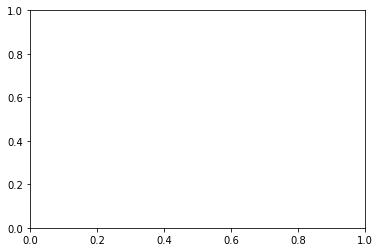

In [17]:
fig, ax = plt.subplots()

one_cam_sites = [site for site in site_cams if (len(site_cams[site]) == 1)]
two_cam_sites = [site for site in site_cams if (len(site_cams[site]) == 2)]

bar_colors = ['grey','darkorange','green']

site_bool_1 = object_data['short']['observation'].index.isin(one_cam_sites)
site_bool_2 = object_data['short']['observation'].index.isin(two_cam_sites)

object_data['short']['observation'][['0_cameras','1_cameras']][site_bool_1].sort_values(by='site', key=lambda col: int(col[1:])).plot.bar(figsize=(25,5),ax=ax,colors=bar_colors[:2], stacked=True,width=0.8,ylim = (0,1),alpha=.99,legend=False)
for i in range(0,len(object_data['short']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xlabel("Single camera rotating sites",fontsize=20)
ax.set_ylim(0,1)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('../results/short_cams_1.pdf', bbox_inches='tight', pad_inches=0.0)

fig, ax = plt.subplots()

object_data['short']['observation'][['0_cameras','1_cameras','2_cameras']][site_bool_2].sort_index().plot.bar(figsize=(25,5),ax=ax,colors=bar_colors, stacked=True,width=0.8,ylim = (0,1),alpha=.99,legend=False)
for i in range(0,len(object_data['short']['observation'][site_bool_2])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xlabel("Double camera rotating sites",fontsize=20)
ax.set_ylim(0,1)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('../results/short_cams_2.pdf', bbox_inches='tight', pad_inches=0.0)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


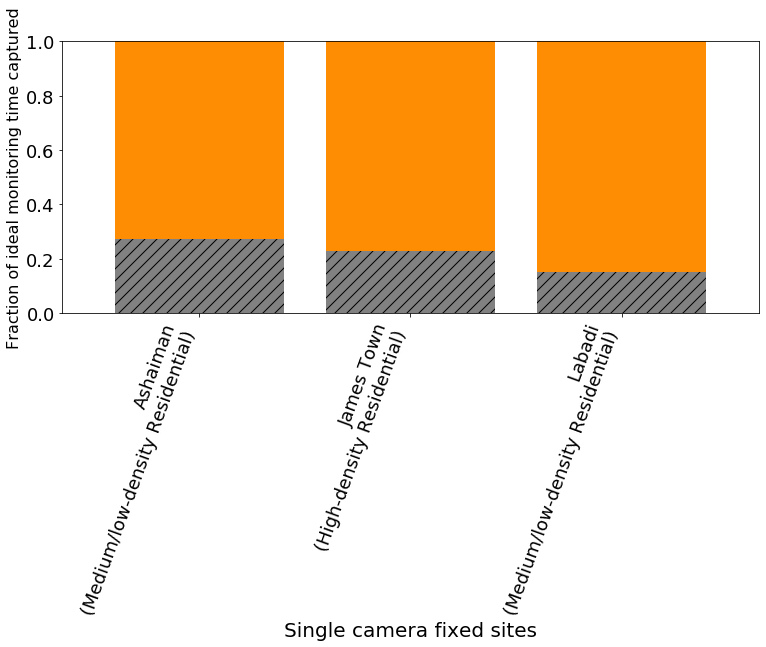

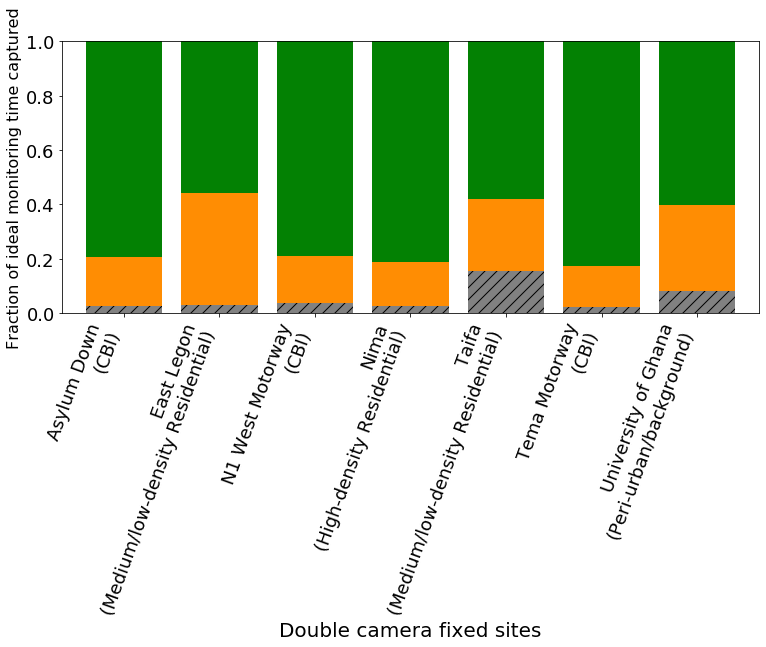

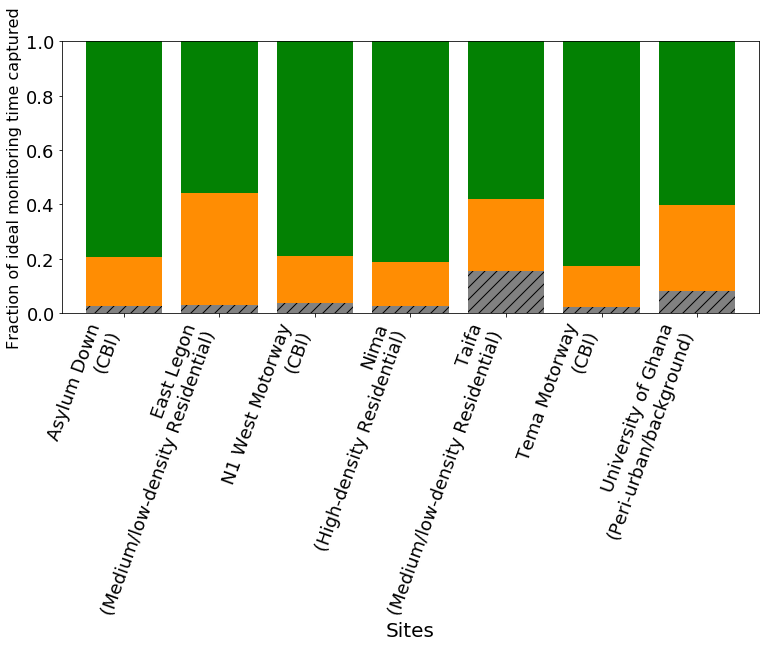

<Figure size 360x360 with 0 Axes>

In [53]:
fig, ax = plt.subplots()

bar_colors = ['grey','darkorange','green']
site_bool_1 = (object_data['long']['observation'].index == 'JT') | (object_data['long']['observation'].index == 'LA') | (object_data['long']['observation'].index == 'ASH')
object_data['long']['observation'][['0_cameras','1_cameras']][site_bool_1].plot.bar(figsize=(12.5,5),ax=ax,colors=bar_colors,stacked=True,ylim = (0,1),width=0.8,alpha=.99,legend=False)
for i in range(0,len(object_data['long']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera"])
ax.set_xticklabels(["Ashaiman\n(Medium/low-density Residential)",
                    "James Town\n(High-density Residential)",
                    "Labadi\n(Medium/low-density Residential)"], rotation=70, ha="right")
ax.set_xlabel("Single camera fixed sites",fontsize=20)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('../results/long_1_cams.pdf', bbox_inches='tight', pad_inches=0.0)

fig, ax = plt.subplots()

site_bool_1 = (object_data['long']['observation'].index != 'JT') & (object_data['long']['observation'].index != 'LA') & (object_data['long']['observation'].index != 'ASH')
object_data['long']['observation'][['0_cameras','1_cameras','2_cameras']][site_bool_1].plot.bar(figsize=(12.5,5),ax=ax,colors=bar_colors,stacked=True,ylim = (0,1),width=0.8,alpha=.99,legend=False)
for i in range(0,len(object_data['long']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xticklabels(["Asylum Down\n(CBI)",
                    "East Legon\n(Medium/low-density Residential)",
                    "N1 West Motorway\n(CBI)",
                    "Nima\n(High-density Residential)",
                    "Taifa\n(Medium/low-density Residential)",
                    "Tema Motorway\n(CBI)",
                    "University of Ghana\n(Peri-urban/background)"], rotation=70, ha="right")
ax.set_xlabel("Double camera fixed sites",fontsize=20)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)

plt.savefig('../results/long_2_cams.pdf', bbox_inches='tight', pad_inches=0.0)

fig, ax = plt.subplots()
figlegend = plt.figure(figsize=(5,5))

site_bool_1 = (object_data['long']['observation'].index != 'JT') & (object_data['long']['observation'].index != 'LA') & (object_data['long']['observation'].index != 'ASH')
object_data['long']['observation'][['0_cameras','1_cameras','2_cameras']][site_bool_1].plot.bar(figsize=(12.5,5),ax=ax,colors=bar_colors,stacked=True,ylim = (0,1),width=0.8,alpha=.99,legend=False)
for i in range(0,len(object_data['long']['observation'][site_bool_1])):
    ax.patches[i].set_hatch('//')
#ax.legend(["No Camera", "One Camera","Two Cameras"])
ax.set_xticklabels(["Asylum Down\n(CBI)",
                    "East Legon\n(Medium/low-density Residential)",
                    "N1 West Motorway\n(CBI)",
                    "Nima\n(High-density Residential)",
                    "Taifa\n(Medium/low-density Residential)",
                    "Tema Motorway\n(CBI)",
                    "University of Ghana\n(Peri-urban background)"], rotation=70, ha="right")
ax.set_xlabel("Sites",fontsize=20)
ax.set_ylabel('Fraction of ideal monitoring time captured',fontsize=16)
handles, labels = ax.get_legend_handles_labels() 

lg = figlegend.legend(handles, ["No Camera", "One Camera","Two Cameras"], title= 'Number of cameras operating', loc='center', fontsize = 25)
lg.get_title().set_fontsize(25)
figlegend.savefig(fname='../results/'+'cam_legend.pdf', format='pdf', bbox_inches = "tight")

#plt.savefig('../results/long_2_cams.pdf', bbox_inches='tight', pad_inches=0.0)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_lay

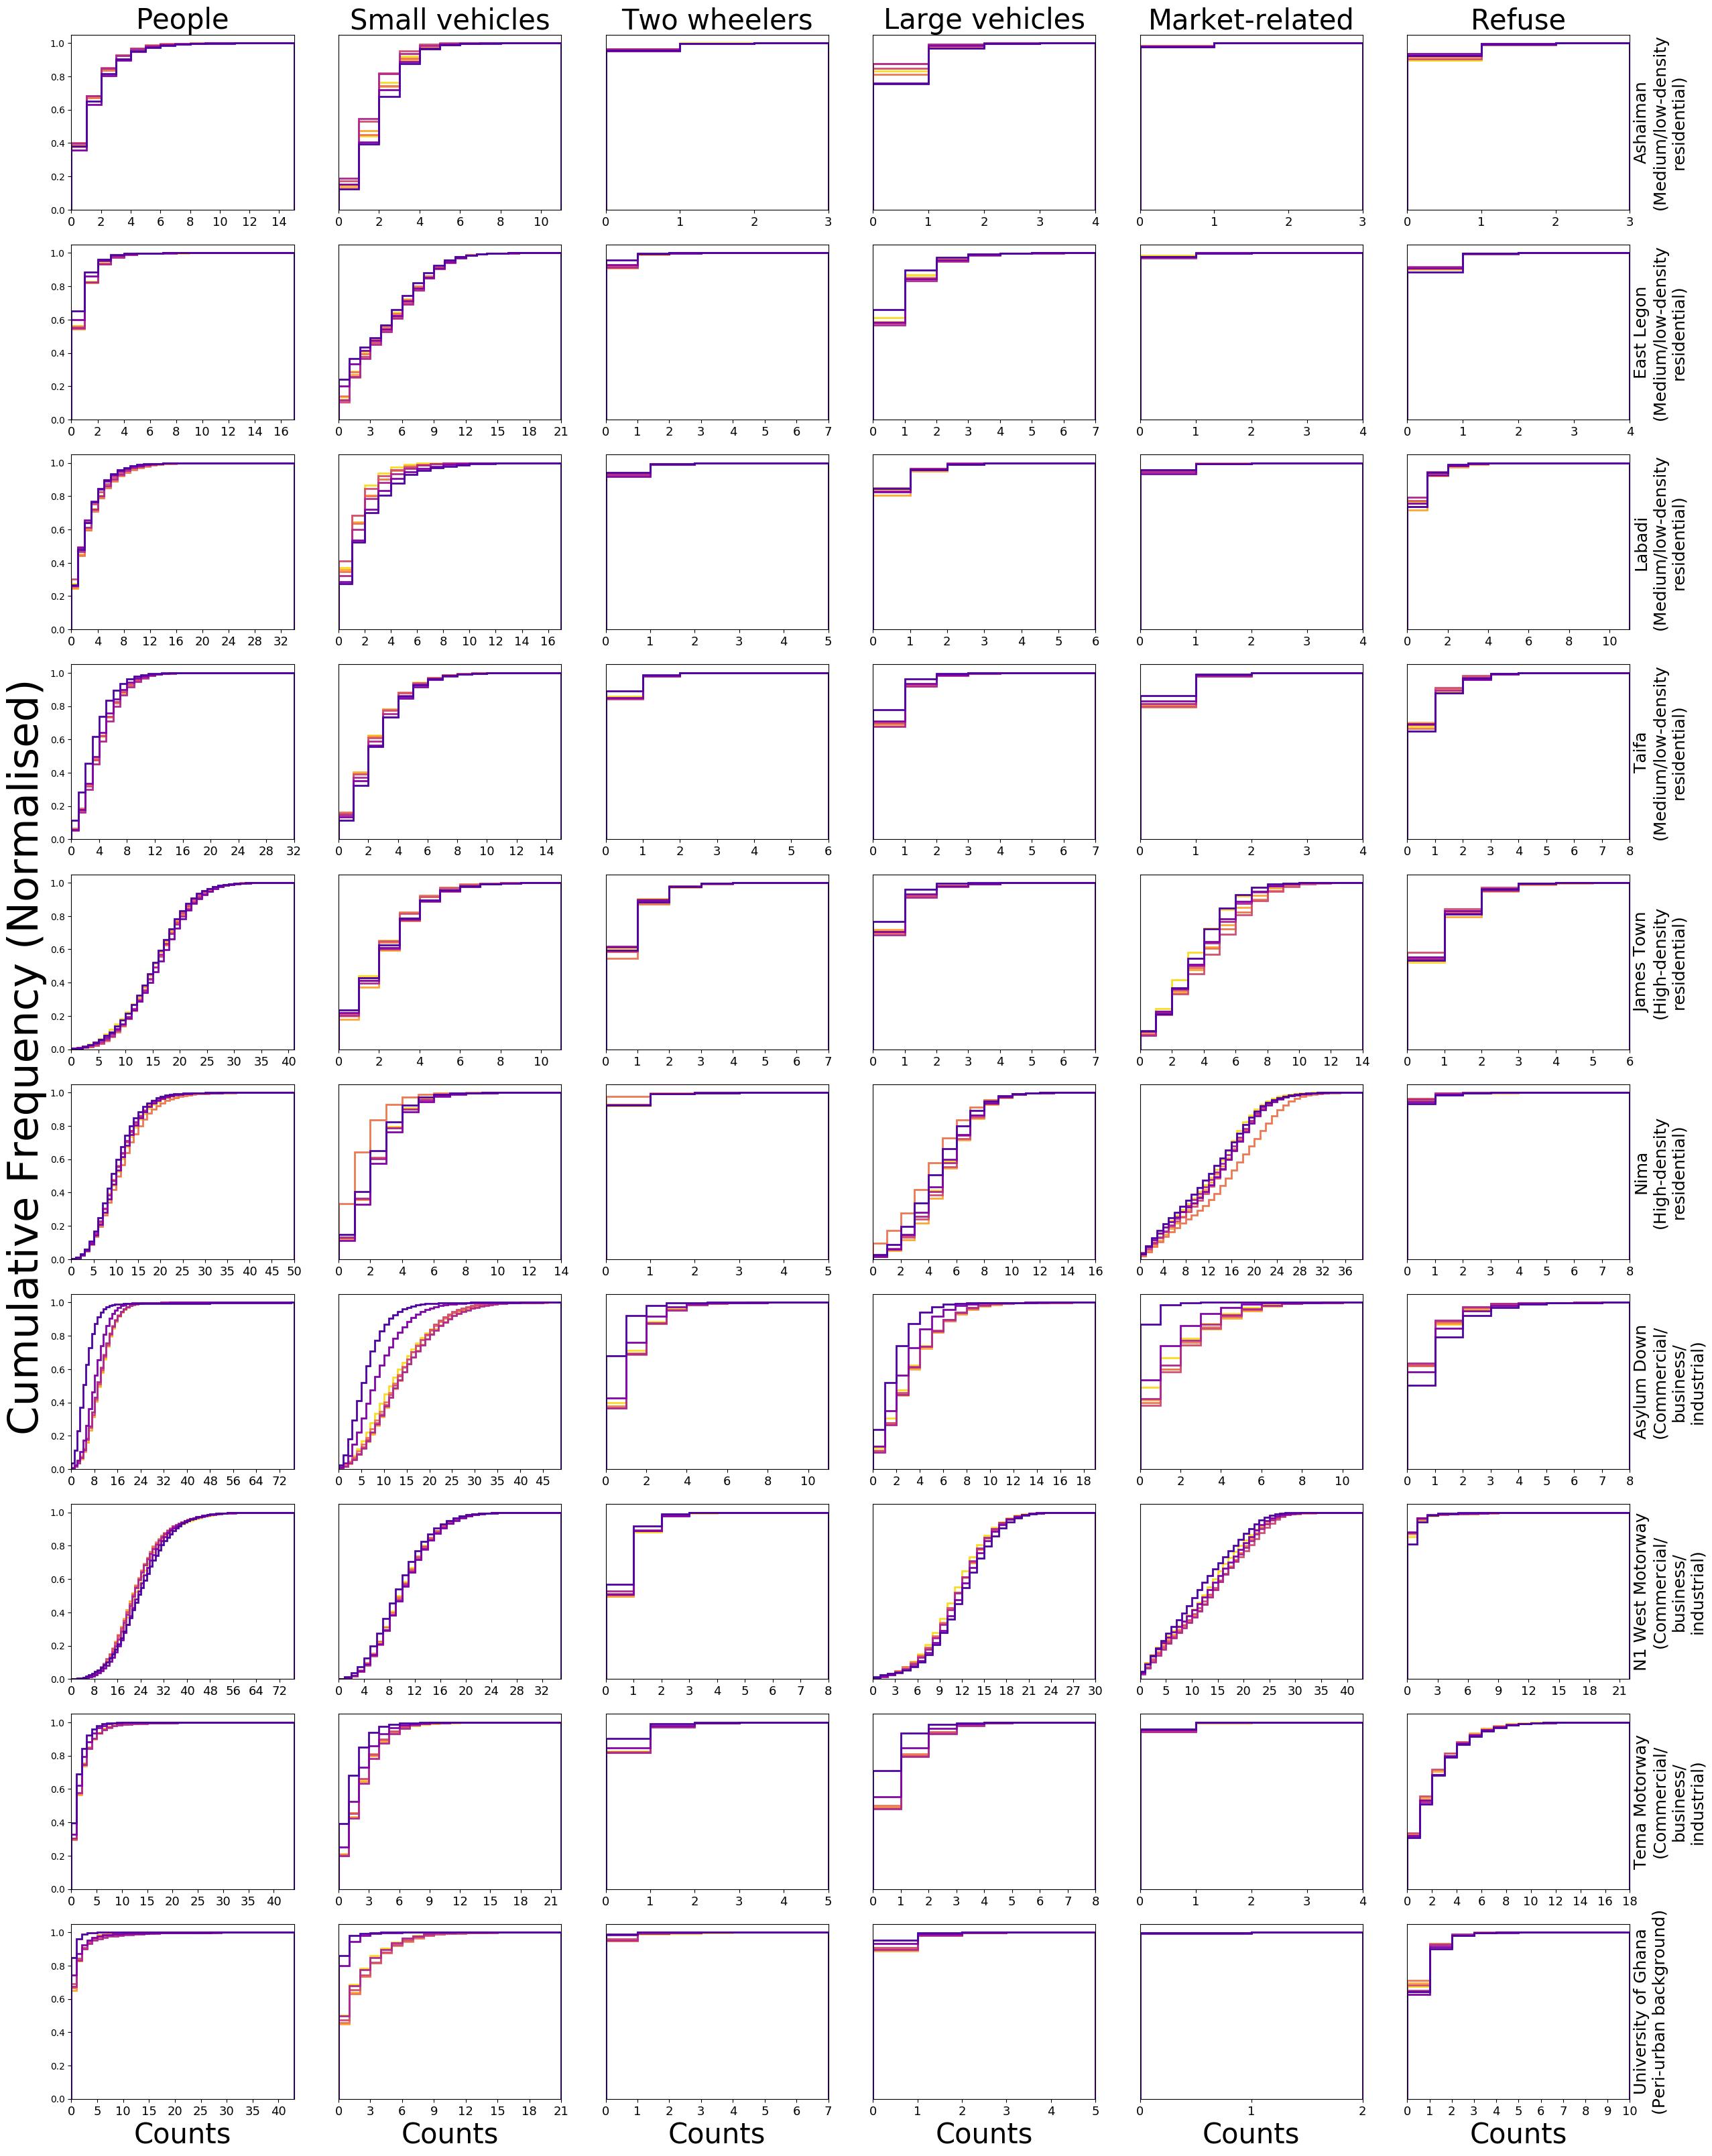

<Figure size 200x1200 with 0 Axes>

In [78]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from pandas import Grouper
import seaborn as sns

week_cols = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#week_colors = ['red','orange','gold','olivedrab','deepskyblue','blueviolet','fuchsia']

cmap = 'plasma'
week_colors = plt.cm.get_cmap(cmap, 16).colors[1:-1][::-1]

#object_cats = ['two_wheelers','small_vehicles']
object_cats = ['people','small_vehicles','two_wheelers', 'large_vehicles', 'market', 'refuse']

fig, ax = plt.subplots(10, len(object_cats),figsize=(5*len(object_cats),40), tight_layout=True)

## Uncomment if you want to produce the legend as a separate figure
figlegend = plt.figure(figsize=(2,12))

site_type = {'AD': ['Asylum Down', 'Commercial/\nbusiness/\nindustrial','blue'],
             'ASH' : ['Ashaiman', 'Medium/low-density\nresidential', 'tab:orange'],
             'EL': ['East Legon', 'Medium/low-density\nresidential', 'tab:orange'],
             'JT' : ['James Town', 'High-density\nresidential', 'red'],
             'LA': ['Labadi', 'Medium/low-density\nresidential', 'tab:orange'],
             'N1West': ['N1 West Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'Nima': ['Nima', 'High-density\nresidential', 'red'],
             'Taifa': ['Taifa','Medium/low-density\nresidential', 'tab:orange'],
             'TMW': ['Tema Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'UGH': ['University of Ghana', 'Peri-urban background', 'green']}

for j,site in enumerate(['ASH', 'EL', 'LA', 'Taifa', 'JT', 'Nima', 'AD', 'N1West', 'TMW', 'UGH']):
    site_cam_frame = pd.DataFrame()
    for cam in site_cams[site]:
        date_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2019,4,10), object_data[site][cam].index <= datetime.datetime(2020,6,11))
        site_cam_frame = site_cam_frame.append(object_data[site][cam][date_bool])

    site_cam_frame.sort_index()
    #for i, obj in enumerate(['person']):
    for i, obj in enumerate(object_cats):
        #print(obj)
        if(site_cam_frame[obj+'_counts'].max() > 1):
                time_cut_day = (site_cam_frame['hm'].astype(int) > 600) & (site_cam_frame['hm'].astype(int) < 1800)
                time_cut_night = (site_cam_frame['hm'].astype(int) < 600) | (site_cam_frame['hm'].astype(int) > 1800)
                series=site_cam_frame[obj+'_counts']
                day_series=site_cam_frame[time_cut_day][obj+'_counts']
                night_series=site_cam_frame[time_cut_night][obj+'_counts']

                groups = series.groupby(series.index.weekday_name)
                day_groups = day_series.groupby(day_series.index.weekday_name)
                night_groups = night_series.groupby(night_series.index.weekday_name)

                days = pd.DataFrame()

                for name, group in day_groups:
                    days[name+" day"] = pd.Series(group.astype(float).values)
                for name, group in night_groups:
                    days[name+" night"] = pd.Series(group.astype(float).values)
                for name, group in groups:
                    days[name] = pd.Series(group.astype(float).values)

                bin_max = int(site_cam_frame[obj+'_counts'].max())
                bins=range(0,bin_max+1,1)

                ax[j,i].clear()
                day_night = "day"
                if(j==0):
                    ax[j,i].set_title(obj.replace('market', 'market-related').capitalize().replace("_"," "),fontsize=30)
            
                for index, day in enumerate(week_cols):
                    if(bin_max < 20):
                        #days[[day+' day']].plot.density(lw = 3, alpha=1,ax=ax,color=week_colors[index], bw_method=2)
                        sns.distplot(days[day+" "+day_night], hist = True, kde = False,
                        #kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': False, "histtype": "stepfilled", "linewidth": 2,"alpha": 0.25},
                        kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': True, "histtype": "step", "linewidth": 2, "alpha": 1},
                        label = day, bins=bins, norm_hist=True, color=tuple(week_colors[index*2]), ax = ax[j,i]) 
                    else:
                        #days[[day+' day']].plot.density(lw = 3, alpha=1,ax=ax,color=week_colors[index])
                        sns.distplot(days[day+" "+day_night], hist = True, kde = False,
                        #kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': False, "histtype": "stepfilled", "linewidth": 2,"alpha": 0.25},
                        kde_kws = {'linewidth': 3,'cumulative': True}, hist_kws={'cumulative': True, "histtype": "step", "linewidth": 2, "alpha": 1},
                        label = day, bins=bins, norm_hist=True, color=tuple(week_colors[index*2]), ax = ax[j,i])

## The following may be added to the cumulative frequency graph to show the median and IQR                        
#                 ax[j,i].axhline(0.25, lw=1,color = 'grey',linestyle='dashed')                                
#                 ax[j,i].axhline(0.5, lw=1,color = 'grey',linestyle='dashed')
#                 ax[j,i].axhline(0.75, lw=1,color = 'grey',linestyle='dashed')
                ax[j,i].set_xlim(0,bin_max)

                #ax[j,i].legend(loc='lower right', framealpha=1)
                ax[j,i].legend().remove()
                ax[j,i].tick_params(axis='x', which='major', labelsize=13)
                ax[j,i].xaxis.set_major_locator(MaxNLocator(integer=True))
                ax[j,i].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
                #ax[j,i].legend(loc='upper right', framealpha=1)
                if(site=='UGH'):
                    ax[j,i].set_xlabel('Counts',fontsize=30)
                else:
                    ax[j,i].xaxis.label.set_visible(False)
                if(i == 0):
                    ax[j,i].get_yaxis().set_visible(True)
                    ax[j,i].get_yaxis().label.set_visible(False)
                elif(i == len(object_cats)-1):
                    ax[j,i].yaxis.set_label_position("right")
                    ax[j,i].set_yticks([], [])
                    ax[j,i].set_ylabel(site_type[site][0]+"\n("+site_type[site][1]+")",color='black',fontsize=18)
                else:
                    ax[j,i].get_yaxis().set_visible(False)
                    #ax[j,i].set_yticks([], [])
                #handles, labels = ax[j,i].get_legend_handles_labels() 
                #ax[j,i].set_ylabel('Frequency')
                #ax[j,i].text(0.70*bin_max, 0.55, site_type[site][1]+":\n"+obj.replace('market', 'market-related').capitalize().replace("_"," "), color=site_type[site][2],fontsize='12',alpha=0.75,horizontalalignment='center', fontweight='bold')
                if(i == 0 and j == 5):
                    ax[j,i].text(-10, -1, 'Cumulative Frequency (Normalised)',fontsize='45',alpha=1,horizontalalignment='center', rotation=90)

#                lg = figlegend.legend(handles, week_cols, title= 'Days of the Week', loc='center', fontsize = 25, ncol = 7)
#lg.get_title().set_fontsize(25)
#figlegend.savefig(fname='../results/day_of_week_hists/cumulative/'+'/'+'legend_'+cmap+'.pdf', format='pdf', bbox_inches = "tight")
fig.show()
fig.savefig(fname='../results/day_of_week_hists/cumulative/'+'/'+'objects'+'_'+day_night+'_'+cmap+'.pdf', format='pdf', bbox_inches = "tight")


In [47]:
lockdown_cams_images=[]

num_cams=0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 1):
            lockdown_cams_images.append(len(object_data[site][cam][lock_bool]))
            num_cams+=1
            print(site+" "+cam+": "+str(len(object_data[site][cam][lock_bool])))
        
            
print(num_cams)

AD C4: 2249
AD C17: 3761
EL C12: 6048
LA C16: 6048
N1West C36: 6048
N1West C15: 5178
Nima C2: 4385
Nima C27: 4618
Taifa C21: 1456
Taifa C22: 1195
TMW C30: 3440
TMW C19: 5308
UGH C33: 493
UGH C25: 4343
14


In [56]:
postlock_total = 0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            postlock_bool = object_data[site][cam].index >= datetime.datetime(2020,4,20)
            if(len(object_data[site][cam][postlock_bool]) > 1 and site[0].lower() != 's'):
                lockdown_cams_images.append(len(object_data[site][cam][postlock_bool]))
                postlock_total += len(object_data[site][cam][postlock_bool])
                num_cams+=1
                #print(site+" "+cam+": "+str(len(object_data[site][cam][postlock_bool])))

print("POST-lockdown contributions from each camera:\n")

num_cams=0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            postlock_bool = object_data[site][cam].index >= datetime.datetime(2020,4,20)
            if(len(object_data[site][cam][postlock_bool]) > 1 and site[0].lower() != 's'):
                print(site+" "+cam+": "+str(len(object_data[site][cam][postlock_bool])/postlock_total))
        

POST-lockdown contributions from each camera:

AD C4: 0.0874475055200381
AD C17: 0.05815161704645491
EL C12: 0.09163984818091293
LA C16: 0.07537557906282019
N1West C36: 0.07423549276261672
N1West C15: 0.08207178214249636
Nima C2: 0.08941740146912387
Nima C27: 0.08732483800672507
Taifa C21: 0.017555885875918203
Taifa C22: 0.011097802086790873
TMW C30: 0.11595687876120243
TMW C19: 0.0846983100746107
UGH C33: 0.03820732252897118
UGH C25: 0.08681973648131847


In [57]:
prelock_total = 0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            prelock_bool = object_data[site][cam].index <= datetime.datetime(2020,3,30)
            if(len(object_data[site][cam][prelock_bool]) > 1 and site[0].lower() != 's'):
                lockdown_cams_images.append(len(object_data[site][cam][prelock_bool]))
                postlock_total += len(object_data[site][cam][prelock_bool])
                num_cams+=1
                #print(site+" "+cam+": "+str(len(object_data[site][cam][postlock_bool])))

print("PRE-lockdown contributions from each camera:\n")

num_cams=0
for site in site_cams:
    for cam in site_cams[site]:
        lock_bool = np.logical_and(object_data[site][cam].index >= datetime.datetime(2020,3,30), object_data[site][cam].index <= datetime.datetime(2020,4,20))
        if(len(object_data[site][cam][lock_bool]) > 100):
            prelock_bool = object_data[site][cam].index <= datetime.datetime(2020,3,30)
            if(len(object_data[site][cam][prelock_bool]) > 1 and site[0].lower() != 's'):
                print(site+" "+cam+": "+str(len(object_data[site][cam][prelock_bool])/postlock_total))
        

PRE-lockdown contributions from each camera:

AD C4: 0.0630965121636677
AD C17: 0.07115605428611131
EL C12: 0.055767513333024536
LA C16: 0.0479972631036632
N1West C36: 0.06426099329509155
N1West C15: 0.07189309851932933
Nima C2: 0.07602363417252361
Nima C27: 0.05493783068460602
Taifa C21: 0.0647103708705817
Taifa C22: 0.06806566925972968
TMW C30: 0.07307058153358834
TMW C19: 0.07416111445638722
UGH C33: 0.04674826973381083
UGH C25: 0.05549366117580902


In [73]:
lockdown_cams = np.array(lockdown_cams_images)
lockdown_cams = lockdown_cams*5/(60*24)
print("Mean number of days camera operated during lockdown: "+str(np.mean(lockdown_cams)))
print("Standard deviation of number of days camera operated during lockdown: "+str(np.std(lockdown_cams)))

q75, q25 = np.percentile(lockdown_cams, [75 ,25])
print("Median number of days camera operated during lockdown: "+str(np.median(lockdown_cams)))
print("25th and 75th perecentile of number of days camera operated during lockdown: "+str(q25)+", "+str(q75))

Mean number of days camera operated during lockdown: 13.53422619047619
Standard deviation of number of days camera operated during lockdown: 6.311626134729517
Median number of days camera operated during lockdown: 15.152777777777779
25th and 75th perecentile of number of days camera operated during lockdown: 8.842881944444445, 18.317708333333336
